In [46]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout

In [2]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [3]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
1,Absol ex - 135/197,['Holofoil Market Price: '],8/2 to 8/4,$4.74
2,Absol ex - 135/197,['Holofoil Market Price: '],8/5 to 8/7,$4.74
3,Absol ex - 135/197,['Holofoil Market Price: '],8/8 to 8/10,$2.04
4,Absol ex - 135/197,['Holofoil Market Price: '],8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/19 to 10/21,$0.06
12926,Zigzagoon,[' Market Price: '],10/22 to 10/24,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/22 to 10/24,$0.05
12928,Zigzagoon,[' Market Price: '],10/25 to 10/27,$0.03


In [4]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [5]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [6]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 7.57% of the dataset has $0.00 market price

0.0757153905645785

In [7]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [8]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,$0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,$0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05


In [9]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [10]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
11946,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
11947,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
11948,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
11949,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [11]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

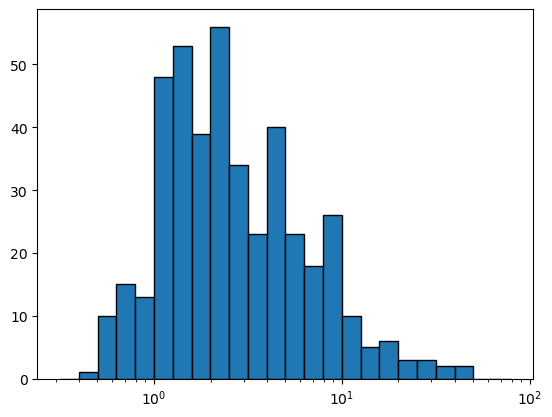

In [12]:
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [13]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 56% of the initial prices are more than double the latest price in the dataset

0.5627906976744186

In [14]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [15]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [16]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05,0.06,0.06


In [17]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.05


In [18]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11
5502,Zigzagoon,Reverse Holofoil,9/22 to 9/24,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.07,0.08,0.09,0.10


# Data Split

In [19]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '9/16 to 9/18',
       '9/19 to 9/21', '9/22 to 9/24', '9/25 to 9/27'], dtype=object)

In [20]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 135/197,Holofoil,9/16 to 9/18,0.96,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,1.16,1.03,1.04,1.00,0.94
12,Absol ex - 135/197,Holofoil,9/19 to 9/21,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.96,1.16,1.03,1.04,1.00
13,Absol ex - 135/197,Holofoil,9/22 to 9/24,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,0.96,0.96,1.16,1.03,1.04
14,Absol ex - 135/197,Holofoil,9/25 to 9/27,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,1.03,1.08,0.96,0.96,1.16,1.03
15,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11


In [21]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
5,Absol ex - 135/197,Holofoil,8/29 to 8/31,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,1.16,0.93,0.92,0.81,0.81,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5493,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
5494,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
5495,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
5496,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [22]:
of_cleaned.iloc[5884]

Product             Lillipup
Foil                  Normal
Date Range      8/23 to 8/25
Market Price            0.06
Name: 5884, dtype: object

In [23]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [24]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [25]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [26]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,0.167060
1,Previous Market Price_2,-0.074821
2,Previous Market Price_3,0.029078
3,Previous Market Price_4,-0.034503
4,Previous Market Price_5,-0.122030
5,Market Price,1.002076
6,Foil_Holofoil,-0.190213
7,Foil_Normal,0.061893
8,Foil_Reverse Holofoil,0.128320


In [27]:
y_pred = classifier.predict(X_test)

In [28]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [29]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9978
r2:  0.9978
MAE:  0.3416
MSE:  3.3686
RMSE:  1.8354


# LSTM

In [30]:
X_train = train[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [31]:
X_train['Market Price']

1       0.81
2       0.81
3       0.92
4       0.93
5       1.01
        ... 
5493    0.07
5494    0.08
5495    0.10
5496    0.11
5497    0.10
Name: Market Price, Length: 1720, dtype: float64

In [67]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063

model = Sequential()  
model.add(LSTM(4, input_dim=1, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4)                 96        
                                                                 
 dense_17 (Dense)            (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,epochs=5000, validation_data=(X_test, y_test))

Epoch 1/5000
54/54 [==============================] - 2s 10ms/step - loss: 1799.6927 - mean_squared_error: 1799.6927 - val_loss: 1561.0964 - val_mean_squared_error: 1561.0964
Epoch 2/5000
54/54 [==============================] - 0s 3ms/step - loss: 1799.3560 - mean_squared_error: 1799.3560 - val_loss: 1560.7810 - val_mean_squared_error: 1560.7810
Epoch 3/5000
54/54 [==============================] - 0s 3ms/step - loss: 1799.0502 - mean_squared_error: 1799.0502 - val_loss: 1560.4672 - val_mean_squared_error: 1560.4672
Epoch 4/5000
54/54 [==============================] - 0s 3ms/step - loss: 1798.7056 - mean_squared_error: 1798.7056 - val_loss: 1560.0941 - val_mean_squared_error: 1560.0941
Epoch 5/5000
54/54 [==============================] - 0s 3ms/step - loss: 1798.2935 - mean_squared_error: 1798.2935 - val_loss: 1559.5831 - val_mean_squared_error: 1559.5831
Epoch 6/5000
54/54 [==============================] - 0s 3ms/step - loss: 1797.1301 - mean_squared_error: 1797.1301 - val_loss: 1

Epoch 48/5000
54/54 [==============================] - 0s 3ms/step - loss: 1734.5106 - mean_squared_error: 1734.5106 - val_loss: 1493.4150 - val_mean_squared_error: 1493.4150
Epoch 49/5000
54/54 [==============================] - 0s 3ms/step - loss: 1733.4542 - mean_squared_error: 1733.4542 - val_loss: 1492.4563 - val_mean_squared_error: 1492.4563
Epoch 50/5000
54/54 [==============================] - 0s 3ms/step - loss: 1732.5380 - mean_squared_error: 1732.5380 - val_loss: 1491.4388 - val_mean_squared_error: 1491.4388
Epoch 51/5000
54/54 [==============================] - 0s 3ms/step - loss: 1731.6520 - mean_squared_error: 1731.6520 - val_loss: 1490.5958 - val_mean_squared_error: 1490.5958
Epoch 52/5000
54/54 [==============================] - 0s 3ms/step - loss: 1730.7418 - mean_squared_error: 1730.7418 - val_loss: 1489.5522 - val_mean_squared_error: 1489.5522
Epoch 53/5000
54/54 [==============================] - 0s 3ms/step - loss: 1729.6588 - mean_squared_error: 1729.6588 - val_lo

Epoch 95/5000
54/54 [==============================] - 0s 4ms/step - loss: 1690.0646 - mean_squared_error: 1690.0646 - val_loss: 1447.5713 - val_mean_squared_error: 1447.5713
Epoch 96/5000
54/54 [==============================] - 0s 4ms/step - loss: 1689.3198 - mean_squared_error: 1689.3198 - val_loss: 1446.7626 - val_mean_squared_error: 1446.7626
Epoch 97/5000
54/54 [==============================] - 0s 4ms/step - loss: 1688.4266 - mean_squared_error: 1688.4266 - val_loss: 1445.8317 - val_mean_squared_error: 1445.8317
Epoch 98/5000
54/54 [==============================] - 0s 4ms/step - loss: 1687.5215 - mean_squared_error: 1687.5215 - val_loss: 1444.9569 - val_mean_squared_error: 1444.9569
Epoch 99/5000
54/54 [==============================] - 0s 4ms/step - loss: 1686.6686 - mean_squared_error: 1686.6686 - val_loss: 1444.0176 - val_mean_squared_error: 1444.0176
Epoch 100/5000
54/54 [==============================] - 0s 3ms/step - loss: 1685.7162 - mean_squared_error: 1685.7162 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1651.6296 - mean_squared_error: 1651.6296 - val_loss: 1407.8976 - val_mean_squared_error: 1407.8976
Epoch 142/5000
54/54 [==============================] - 0s 3ms/step - loss: 1650.8309 - mean_squared_error: 1650.8309 - val_loss: 1407.0898 - val_mean_squared_error: 1407.0898
Epoch 143/5000
54/54 [==============================] - 0s 3ms/step - loss: 1650.0031 - mean_squared_error: 1650.0031 - val_loss: 1406.2688 - val_mean_squared_error: 1406.2688
Epoch 144/5000
54/54 [==============================] - 0s 3ms/step - loss: 1649.2815 - mean_squared_error: 1649.2815 - val_loss: 1405.4335 - val_mean_squared_error: 1405.4335
Epoch 145/5000
54/54 [==============================] - 0s 3ms/step - loss: 1648.5331 - mean_squared_error: 1648.5331 - val_loss: 1404.7235 - val_mean_squared_error: 1404.7235
Epoch 146/5000
54/54 [==============================] - 0s 3ms/step - loss: 1647.7148 - mean_squared_error: 1647.7148 - val_loss: 1403.

54/54 [==============================] - 0s 3ms/step - loss: 1616.1035 - mean_squared_error: 1616.1035 - val_loss: 1371.1630 - val_mean_squared_error: 1371.1630
Epoch 188/5000
54/54 [==============================] - 0s 3ms/step - loss: 1615.2979 - mean_squared_error: 1615.2979 - val_loss: 1370.3044 - val_mean_squared_error: 1370.3044
Epoch 189/5000
54/54 [==============================] - 0s 3ms/step - loss: 1614.5588 - mean_squared_error: 1614.5588 - val_loss: 1369.4752 - val_mean_squared_error: 1369.4752
Epoch 190/5000
54/54 [==============================] - 0s 3ms/step - loss: 1613.7415 - mean_squared_error: 1613.7415 - val_loss: 1368.6941 - val_mean_squared_error: 1368.6941
Epoch 191/5000
54/54 [==============================] - 0s 3ms/step - loss: 1613.0525 - mean_squared_error: 1613.0525 - val_loss: 1367.9630 - val_mean_squared_error: 1367.9630
Epoch 192/5000
54/54 [==============================] - 0s 3ms/step - loss: 1612.2246 - mean_squared_error: 1612.2246 - val_loss: 1367.

54/54 [==============================] - 0s 3ms/step - loss: 1582.3459 - mean_squared_error: 1582.3459 - val_loss: 1336.2926 - val_mean_squared_error: 1336.2926
Epoch 234/5000
54/54 [==============================] - 0s 3ms/step - loss: 1581.7286 - mean_squared_error: 1581.7286 - val_loss: 1335.6040 - val_mean_squared_error: 1335.6040
Epoch 235/5000
54/54 [==============================] - 0s 3ms/step - loss: 1580.9657 - mean_squared_error: 1580.9657 - val_loss: 1334.7904 - val_mean_squared_error: 1334.7904
Epoch 236/5000
54/54 [==============================] - 0s 3ms/step - loss: 1580.2996 - mean_squared_error: 1580.2996 - val_loss: 1334.1322 - val_mean_squared_error: 1334.1322
Epoch 237/5000
54/54 [==============================] - 0s 3ms/step - loss: 1579.5868 - mean_squared_error: 1579.5868 - val_loss: 1333.3547 - val_mean_squared_error: 1333.3547
Epoch 238/5000
54/54 [==============================] - 0s 3ms/step - loss: 1578.7920 - mean_squared_error: 1578.7920 - val_loss: 1332.

54/54 [==============================] - 0s 3ms/step - loss: 1549.9746 - mean_squared_error: 1549.9746 - val_loss: 1302.8740 - val_mean_squared_error: 1302.8740
Epoch 280/5000
54/54 [==============================] - 0s 3ms/step - loss: 1549.2444 - mean_squared_error: 1549.2444 - val_loss: 1302.1290 - val_mean_squared_error: 1302.1290
Epoch 281/5000
54/54 [==============================] - 0s 4ms/step - loss: 1548.4739 - mean_squared_error: 1548.4739 - val_loss: 1301.3522 - val_mean_squared_error: 1301.3522
Epoch 282/5000
54/54 [==============================] - 0s 3ms/step - loss: 1547.7606 - mean_squared_error: 1547.7606 - val_loss: 1300.6316 - val_mean_squared_error: 1300.6316
Epoch 283/5000
54/54 [==============================] - 0s 3ms/step - loss: 1547.0956 - mean_squared_error: 1547.0956 - val_loss: 1299.9952 - val_mean_squared_error: 1299.9952
Epoch 284/5000
54/54 [==============================] - 0s 3ms/step - loss: 1546.4510 - mean_squared_error: 1546.4510 - val_loss: 1299.

54/54 [==============================] - 0s 3ms/step - loss: 1519.0281 - mean_squared_error: 1519.0281 - val_loss: 1271.2201 - val_mean_squared_error: 1271.2201
Epoch 326/5000
54/54 [==============================] - 0s 3ms/step - loss: 1518.4436 - mean_squared_error: 1518.4436 - val_loss: 1270.6194 - val_mean_squared_error: 1270.6194
Epoch 327/5000
54/54 [==============================] - 0s 3ms/step - loss: 1517.7860 - mean_squared_error: 1517.7860 - val_loss: 1269.8647 - val_mean_squared_error: 1269.8647
Epoch 328/5000
54/54 [==============================] - 0s 3ms/step - loss: 1517.0519 - mean_squared_error: 1517.0519 - val_loss: 1269.1584 - val_mean_squared_error: 1269.1584
Epoch 329/5000
54/54 [==============================] - 0s 3ms/step - loss: 1516.3352 - mean_squared_error: 1516.3352 - val_loss: 1268.4604 - val_mean_squared_error: 1268.4604
Epoch 330/5000
54/54 [==============================] - 0s 3ms/step - loss: 1515.7249 - mean_squared_error: 1515.7249 - val_loss: 1267.

54/54 [==============================] - 0s 4ms/step - loss: 1489.6591 - mean_squared_error: 1489.6591 - val_loss: 1241.2854 - val_mean_squared_error: 1241.2854
Epoch 372/5000
54/54 [==============================] - 0s 3ms/step - loss: 1489.0891 - mean_squared_error: 1489.0891 - val_loss: 1240.7158 - val_mean_squared_error: 1240.7158
Epoch 373/5000
54/54 [==============================] - 0s 3ms/step - loss: 1488.4520 - mean_squared_error: 1488.4520 - val_loss: 1240.0179 - val_mean_squared_error: 1240.0179
Epoch 374/5000
54/54 [==============================] - 0s 3ms/step - loss: 1487.8275 - mean_squared_error: 1487.8275 - val_loss: 1239.4663 - val_mean_squared_error: 1239.4663
Epoch 375/5000
54/54 [==============================] - 0s 3ms/step - loss: 1487.2731 - mean_squared_error: 1487.2731 - val_loss: 1238.8507 - val_mean_squared_error: 1238.8507
Epoch 376/5000
54/54 [==============================] - 0s 3ms/step - loss: 1486.6600 - mean_squared_error: 1486.6600 - val_loss: 1238.

54/54 [==============================] - 0s 3ms/step - loss: 1461.4818 - mean_squared_error: 1461.4818 - val_loss: 1212.6559 - val_mean_squared_error: 1212.6559
Epoch 418/5000
54/54 [==============================] - 0s 3ms/step - loss: 1460.8760 - mean_squared_error: 1460.8760 - val_loss: 1212.1785 - val_mean_squared_error: 1212.1785
Epoch 419/5000
54/54 [==============================] - 0s 3ms/step - loss: 1460.2921 - mean_squared_error: 1460.2921 - val_loss: 1211.3873 - val_mean_squared_error: 1211.3873
Epoch 420/5000
54/54 [==============================] - 0s 3ms/step - loss: 1459.6371 - mean_squared_error: 1459.6371 - val_loss: 1210.7844 - val_mean_squared_error: 1210.7844
Epoch 421/5000
54/54 [==============================] - 0s 3ms/step - loss: 1459.0375 - mean_squared_error: 1459.0375 - val_loss: 1210.2738 - val_mean_squared_error: 1210.2738
Epoch 422/5000
54/54 [==============================] - 0s 3ms/step - loss: 1458.4221 - mean_squared_error: 1458.4221 - val_loss: 1209.

54/54 [==============================] - 0s 3ms/step - loss: 1434.0980 - mean_squared_error: 1434.0980 - val_loss: 1185.1302 - val_mean_squared_error: 1185.1302
Epoch 464/5000
54/54 [==============================] - 0s 3ms/step - loss: 1433.5413 - mean_squared_error: 1433.5413 - val_loss: 1184.4775 - val_mean_squared_error: 1184.4775
Epoch 465/5000
54/54 [==============================] - 0s 3ms/step - loss: 1433.0099 - mean_squared_error: 1433.0099 - val_loss: 1183.8665 - val_mean_squared_error: 1183.8665
Epoch 466/5000
54/54 [==============================] - 0s 3ms/step - loss: 1432.4092 - mean_squared_error: 1432.4092 - val_loss: 1183.3474 - val_mean_squared_error: 1183.3474
Epoch 467/5000
54/54 [==============================] - 0s 3ms/step - loss: 1431.8055 - mean_squared_error: 1431.8055 - val_loss: 1182.8019 - val_mean_squared_error: 1182.8019
Epoch 468/5000
54/54 [==============================] - 0s 3ms/step - loss: 1431.1843 - mean_squared_error: 1431.1843 - val_loss: 1182.

54/54 [==============================] - 0s 3ms/step - loss: 1407.6232 - mean_squared_error: 1407.6232 - val_loss: 1158.3208 - val_mean_squared_error: 1158.3208
Epoch 510/5000
54/54 [==============================] - 0s 3ms/step - loss: 1407.0615 - mean_squared_error: 1407.0615 - val_loss: 1157.9042 - val_mean_squared_error: 1157.9042
Epoch 511/5000
54/54 [==============================] - 0s 3ms/step - loss: 1406.4888 - mean_squared_error: 1406.4888 - val_loss: 1157.4286 - val_mean_squared_error: 1157.4286
Epoch 512/5000
54/54 [==============================] - 0s 3ms/step - loss: 1405.9038 - mean_squared_error: 1405.9038 - val_loss: 1156.9852 - val_mean_squared_error: 1156.9852
Epoch 513/5000
54/54 [==============================] - 0s 3ms/step - loss: 1405.3530 - mean_squared_error: 1405.3530 - val_loss: 1156.3035 - val_mean_squared_error: 1156.3035
Epoch 514/5000
54/54 [==============================] - 0s 3ms/step - loss: 1404.9434 - mean_squared_error: 1404.9434 - val_loss: 1155.

54/54 [==============================] - 0s 3ms/step - loss: 1382.4192 - mean_squared_error: 1382.4192 - val_loss: 1133.2172 - val_mean_squared_error: 1133.2172
Epoch 556/5000
54/54 [==============================] - 0s 4ms/step - loss: 1381.8834 - mean_squared_error: 1381.8834 - val_loss: 1132.5265 - val_mean_squared_error: 1132.5265
Epoch 557/5000
54/54 [==============================] - 0s 3ms/step - loss: 1381.2861 - mean_squared_error: 1381.2861 - val_loss: 1131.8827 - val_mean_squared_error: 1131.8827
Epoch 558/5000
54/54 [==============================] - 0s 3ms/step - loss: 1380.7043 - mean_squared_error: 1380.7043 - val_loss: 1131.4078 - val_mean_squared_error: 1131.4078
Epoch 559/5000
54/54 [==============================] - 0s 3ms/step - loss: 1380.1256 - mean_squared_error: 1380.1256 - val_loss: 1130.7450 - val_mean_squared_error: 1130.7450
Epoch 560/5000
54/54 [==============================] - 0s 3ms/step - loss: 1379.6271 - mean_squared_error: 1379.6271 - val_loss: 1130.

54/54 [==============================] - 0s 3ms/step - loss: 1357.8308 - mean_squared_error: 1357.8308 - val_loss: 1108.7593 - val_mean_squared_error: 1108.7593
Epoch 602/5000
54/54 [==============================] - 0s 3ms/step - loss: 1357.2622 - mean_squared_error: 1357.2622 - val_loss: 1108.0442 - val_mean_squared_error: 1108.0442
Epoch 603/5000
54/54 [==============================] - 0s 3ms/step - loss: 1356.7593 - mean_squared_error: 1356.7593 - val_loss: 1107.4020 - val_mean_squared_error: 1107.4020
Epoch 604/5000
54/54 [==============================] - 0s 3ms/step - loss: 1356.2203 - mean_squared_error: 1356.2203 - val_loss: 1106.9543 - val_mean_squared_error: 1106.9543
Epoch 605/5000
54/54 [==============================] - 0s 3ms/step - loss: 1355.6615 - mean_squared_error: 1355.6615 - val_loss: 1106.3705 - val_mean_squared_error: 1106.3705
Epoch 606/5000
54/54 [==============================] - 0s 3ms/step - loss: 1355.1599 - mean_squared_error: 1355.1599 - val_loss: 1105.

54/54 [==============================] - 0s 4ms/step - loss: 1334.5582 - mean_squared_error: 1334.5582 - val_loss: 1085.5002 - val_mean_squared_error: 1085.5002
Epoch 648/5000
54/54 [==============================] - 0s 4ms/step - loss: 1334.0806 - mean_squared_error: 1334.0806 - val_loss: 1084.8953 - val_mean_squared_error: 1084.8953
Epoch 649/5000
54/54 [==============================] - 0s 3ms/step - loss: 1333.5696 - mean_squared_error: 1333.5696 - val_loss: 1084.5242 - val_mean_squared_error: 1084.5242
Epoch 650/5000
54/54 [==============================] - 0s 4ms/step - loss: 1333.1456 - mean_squared_error: 1333.1456 - val_loss: 1083.7883 - val_mean_squared_error: 1083.7883
Epoch 651/5000
54/54 [==============================] - 0s 3ms/step - loss: 1332.6469 - mean_squared_error: 1332.6469 - val_loss: 1083.5759 - val_mean_squared_error: 1083.5759
Epoch 652/5000
54/54 [==============================] - 0s 3ms/step - loss: 1332.1069 - mean_squared_error: 1332.1068 - val_loss: 1082.

54/54 [==============================] - 0s 3ms/step - loss: 1312.7095 - mean_squared_error: 1312.7095 - val_loss: 1064.1436 - val_mean_squared_error: 1064.1436
Epoch 694/5000
54/54 [==============================] - 0s 3ms/step - loss: 1312.2532 - mean_squared_error: 1312.2532 - val_loss: 1063.1560 - val_mean_squared_error: 1063.1560
Epoch 695/5000
54/54 [==============================] - 0s 3ms/step - loss: 1311.7310 - mean_squared_error: 1311.7310 - val_loss: 1062.8475 - val_mean_squared_error: 1062.8475
Epoch 696/5000
54/54 [==============================] - 0s 3ms/step - loss: 1311.2332 - mean_squared_error: 1311.2332 - val_loss: 1062.3185 - val_mean_squared_error: 1062.3185
Epoch 697/5000
54/54 [==============================] - 0s 3ms/step - loss: 1310.7401 - mean_squared_error: 1310.7401 - val_loss: 1061.6498 - val_mean_squared_error: 1061.6498
Epoch 698/5000
54/54 [==============================] - 0s 3ms/step - loss: 1310.2278 - mean_squared_error: 1310.2278 - val_loss: 1061.

54/54 [==============================] - 0s 3ms/step - loss: 1291.1161 - mean_squared_error: 1291.1161 - val_loss: 1041.9584 - val_mean_squared_error: 1041.9584
Epoch 740/5000
54/54 [==============================] - 0s 3ms/step - loss: 1290.6735 - mean_squared_error: 1290.6735 - val_loss: 1041.6868 - val_mean_squared_error: 1041.6868
Epoch 741/5000
54/54 [==============================] - 0s 3ms/step - loss: 1290.1976 - mean_squared_error: 1290.1976 - val_loss: 1041.1624 - val_mean_squared_error: 1041.1624
Epoch 742/5000
54/54 [==============================] - 0s 3ms/step - loss: 1289.7393 - mean_squared_error: 1289.7393 - val_loss: 1040.0814 - val_mean_squared_error: 1040.0814
Epoch 743/5000
54/54 [==============================] - 0s 3ms/step - loss: 1289.4655 - mean_squared_error: 1289.4655 - val_loss: 1040.5804 - val_mean_squared_error: 1040.5804
Epoch 744/5000
54/54 [==============================] - 0s 3ms/step - loss: 1289.0559 - mean_squared_error: 1289.0559 - val_loss: 1040.

54/54 [==============================] - 0s 3ms/step - loss: 1270.2274 - mean_squared_error: 1270.2274 - val_loss: 1019.1800 - val_mean_squared_error: 1019.1800
Epoch 786/5000
54/54 [==============================] - 0s 3ms/step - loss: 1269.7627 - mean_squared_error: 1269.7627 - val_loss: 1017.9225 - val_mean_squared_error: 1017.9225
Epoch 787/5000
54/54 [==============================] - 0s 3ms/step - loss: 1269.3085 - mean_squared_error: 1269.3085 - val_loss: 1017.8262 - val_mean_squared_error: 1017.8262
Epoch 788/5000
54/54 [==============================] - 0s 3ms/step - loss: 1268.8177 - mean_squared_error: 1268.8177 - val_loss: 1017.1779 - val_mean_squared_error: 1017.1779
Epoch 789/5000
54/54 [==============================] - 0s 3ms/step - loss: 1268.3185 - mean_squared_error: 1268.3185 - val_loss: 1016.7115 - val_mean_squared_error: 1016.7115
Epoch 790/5000
54/54 [==============================] - 0s 3ms/step - loss: 1267.9435 - mean_squared_error: 1267.9435 - val_loss: 1016.

Epoch 832/5000
54/54 [==============================] - 0s 3ms/step - loss: 1249.1077 - mean_squared_error: 1249.1077 - val_loss: 997.3039 - val_mean_squared_error: 997.3039
Epoch 833/5000
54/54 [==============================] - 0s 4ms/step - loss: 1248.5831 - mean_squared_error: 1248.5831 - val_loss: 996.3397 - val_mean_squared_error: 996.3397
Epoch 834/5000
54/54 [==============================] - 0s 3ms/step - loss: 1248.1355 - mean_squared_error: 1248.1355 - val_loss: 995.9741 - val_mean_squared_error: 995.9741
Epoch 835/5000
54/54 [==============================] - 0s 3ms/step - loss: 1247.7203 - mean_squared_error: 1247.7203 - val_loss: 995.5325 - val_mean_squared_error: 995.5325
Epoch 836/5000
54/54 [==============================] - 0s 3ms/step - loss: 1247.2579 - mean_squared_error: 1247.2579 - val_loss: 995.1396 - val_mean_squared_error: 995.1396
Epoch 837/5000
54/54 [==============================] - 0s 3ms/step - loss: 1246.7864 - mean_squared_error: 1246.7864 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1227.9462 - mean_squared_error: 1227.9462 - val_loss: 975.9629 - val_mean_squared_error: 975.9629
Epoch 880/5000
54/54 [==============================] - 0s 3ms/step - loss: 1227.5673 - mean_squared_error: 1227.5673 - val_loss: 975.2599 - val_mean_squared_error: 975.2599
Epoch 881/5000
54/54 [==============================] - 0s 3ms/step - loss: 1227.1085 - mean_squared_error: 1227.1085 - val_loss: 974.9252 - val_mean_squared_error: 974.9252
Epoch 882/5000
54/54 [==============================] - 0s 3ms/step - loss: 1226.7286 - mean_squared_error: 1226.7286 - val_loss: 974.5188 - val_mean_squared_error: 974.5188
Epoch 883/5000
54/54 [==============================] - 0s 3ms/step - loss: 1226.1488 - mean_squared_error: 1226.1488 - val_loss: 974.1353 - val_mean_squared_error: 974.1353
Epoch 884/5000
54/54 [==============================] - 0s 3ms/step - loss: 1225.7615 - mean_squared_error: 1225.7615 - val_loss: 973.4336 - val_

54/54 [==============================] - 0s 3ms/step - loss: 1207.2418 - mean_squared_error: 1207.2418 - val_loss: 954.9864 - val_mean_squared_error: 954.9864
Epoch 927/5000
54/54 [==============================] - 0s 4ms/step - loss: 1206.6652 - mean_squared_error: 1206.6652 - val_loss: 955.2322 - val_mean_squared_error: 955.2322
Epoch 928/5000
54/54 [==============================] - 0s 3ms/step - loss: 1206.4587 - mean_squared_error: 1206.4587 - val_loss: 954.2300 - val_mean_squared_error: 954.2300
Epoch 929/5000
54/54 [==============================] - 0s 3ms/step - loss: 1205.9337 - mean_squared_error: 1205.9337 - val_loss: 953.5883 - val_mean_squared_error: 953.5883
Epoch 930/5000
54/54 [==============================] - 0s 4ms/step - loss: 1205.4930 - mean_squared_error: 1205.4930 - val_loss: 953.1718 - val_mean_squared_error: 953.1718
Epoch 931/5000
54/54 [==============================] - 0s 4ms/step - loss: 1205.0675 - mean_squared_error: 1205.0675 - val_loss: 952.7841 - val_

54/54 [==============================] - 0s 3ms/step - loss: 1186.2875 - mean_squared_error: 1186.2875 - val_loss: 934.0004 - val_mean_squared_error: 934.0004
Epoch 974/5000
54/54 [==============================] - 0s 3ms/step - loss: 1185.8483 - mean_squared_error: 1185.8483 - val_loss: 933.5048 - val_mean_squared_error: 933.5048
Epoch 975/5000
54/54 [==============================] - 0s 3ms/step - loss: 1185.4342 - mean_squared_error: 1185.4342 - val_loss: 932.8460 - val_mean_squared_error: 932.8460
Epoch 976/5000
54/54 [==============================] - 0s 3ms/step - loss: 1185.0353 - mean_squared_error: 1185.0353 - val_loss: 932.4114 - val_mean_squared_error: 932.4114
Epoch 977/5000
54/54 [==============================] - 0s 3ms/step - loss: 1184.4729 - mean_squared_error: 1184.4729 - val_loss: 931.9692 - val_mean_squared_error: 931.9692
Epoch 978/5000
54/54 [==============================] - 0s 3ms/step - loss: 1183.9456 - mean_squared_error: 1183.9456 - val_loss: 931.5158 - val_

54/54 [==============================] - 0s 3ms/step - loss: 1165.4482 - mean_squared_error: 1165.4482 - val_loss: 913.4005 - val_mean_squared_error: 913.4005
Epoch 1021/5000
54/54 [==============================] - 0s 3ms/step - loss: 1165.1267 - mean_squared_error: 1165.1267 - val_loss: 912.9959 - val_mean_squared_error: 912.9959
Epoch 1022/5000
54/54 [==============================] - 0s 3ms/step - loss: 1164.7289 - mean_squared_error: 1164.7289 - val_loss: 912.4798 - val_mean_squared_error: 912.4798
Epoch 1023/5000
54/54 [==============================] - 0s 3ms/step - loss: 1164.2290 - mean_squared_error: 1164.2290 - val_loss: 912.0302 - val_mean_squared_error: 912.0302
Epoch 1024/5000
54/54 [==============================] - 0s 3ms/step - loss: 1163.8497 - mean_squared_error: 1163.8497 - val_loss: 911.6389 - val_mean_squared_error: 911.6389
Epoch 1025/5000
54/54 [==============================] - 0s 3ms/step - loss: 1163.4630 - mean_squared_error: 1163.4630 - val_loss: 911.2017 -

Epoch 1067/5000
54/54 [==============================] - 0s 3ms/step - loss: 1145.1600 - mean_squared_error: 1145.1600 - val_loss: 893.6823 - val_mean_squared_error: 893.6823
Epoch 1068/5000
54/54 [==============================] - 0s 4ms/step - loss: 1144.5215 - mean_squared_error: 1144.5215 - val_loss: 894.4513 - val_mean_squared_error: 894.4513
Epoch 1069/5000
54/54 [==============================] - 0s 3ms/step - loss: 1144.2980 - mean_squared_error: 1144.2980 - val_loss: 892.6141 - val_mean_squared_error: 892.6141
Epoch 1070/5000
54/54 [==============================] - 0s 3ms/step - loss: 1143.8416 - mean_squared_error: 1143.8416 - val_loss: 892.3916 - val_mean_squared_error: 892.3916
Epoch 1071/5000
54/54 [==============================] - 0s 3ms/step - loss: 1143.4563 - mean_squared_error: 1143.4563 - val_loss: 892.0989 - val_mean_squared_error: 892.0989
Epoch 1072/5000
54/54 [==============================] - 0s 3ms/step - loss: 1142.9708 - mean_squared_error: 1142.9708 - val_

Epoch 1114/5000
54/54 [==============================] - 0s 3ms/step - loss: 1125.0861 - mean_squared_error: 1125.0861 - val_loss: 874.1432 - val_mean_squared_error: 874.1432
Epoch 1115/5000
54/54 [==============================] - 0s 3ms/step - loss: 1124.6737 - mean_squared_error: 1124.6737 - val_loss: 873.7495 - val_mean_squared_error: 873.7495
Epoch 1116/5000
54/54 [==============================] - 0s 3ms/step - loss: 1124.1901 - mean_squared_error: 1124.1901 - val_loss: 873.2997 - val_mean_squared_error: 873.2997
Epoch 1117/5000
54/54 [==============================] - 0s 3ms/step - loss: 1123.7587 - mean_squared_error: 1123.7587 - val_loss: 872.9918 - val_mean_squared_error: 872.9918
Epoch 1118/5000
54/54 [==============================] - 0s 3ms/step - loss: 1123.4088 - mean_squared_error: 1123.4088 - val_loss: 872.3254 - val_mean_squared_error: 872.3254
Epoch 1119/5000
54/54 [==============================] - 0s 3ms/step - loss: 1122.9713 - mean_squared_error: 1122.9713 - val_

Epoch 1161/5000
54/54 [==============================] - 0s 3ms/step - loss: 1104.7928 - mean_squared_error: 1104.7928 - val_loss: 854.6811 - val_mean_squared_error: 854.6811
Epoch 1162/5000
54/54 [==============================] - 0s 3ms/step - loss: 1104.3092 - mean_squared_error: 1104.3092 - val_loss: 854.8658 - val_mean_squared_error: 854.8658
Epoch 1163/5000
54/54 [==============================] - 0s 3ms/step - loss: 1103.8866 - mean_squared_error: 1103.8866 - val_loss: 854.2878 - val_mean_squared_error: 854.2878
Epoch 1164/5000
54/54 [==============================] - 0s 3ms/step - loss: 1103.3755 - mean_squared_error: 1103.3755 - val_loss: 853.7043 - val_mean_squared_error: 853.7043
Epoch 1165/5000
54/54 [==============================] - 0s 3ms/step - loss: 1103.0042 - mean_squared_error: 1103.0042 - val_loss: 853.1302 - val_mean_squared_error: 853.1302
Epoch 1166/5000
54/54 [==============================] - 0s 3ms/step - loss: 1102.7059 - mean_squared_error: 1102.7059 - val_

Epoch 1208/5000
54/54 [==============================] - 0s 3ms/step - loss: 1084.4454 - mean_squared_error: 1084.4454 - val_loss: 838.8207 - val_mean_squared_error: 838.8207
Epoch 1209/5000
54/54 [==============================] - 0s 3ms/step - loss: 1084.1588 - mean_squared_error: 1084.1588 - val_loss: 834.9434 - val_mean_squared_error: 834.9434
Epoch 1210/5000
54/54 [==============================] - 0s 3ms/step - loss: 1083.7880 - mean_squared_error: 1083.7880 - val_loss: 834.7616 - val_mean_squared_error: 834.7616
Epoch 1211/5000
54/54 [==============================] - 0s 3ms/step - loss: 1083.2876 - mean_squared_error: 1083.2876 - val_loss: 834.0282 - val_mean_squared_error: 834.0282
Epoch 1212/5000
54/54 [==============================] - 0s 3ms/step - loss: 1082.7451 - mean_squared_error: 1082.7451 - val_loss: 833.9458 - val_mean_squared_error: 833.9458
Epoch 1213/5000
54/54 [==============================] - 0s 3ms/step - loss: 1082.3271 - mean_squared_error: 1082.3271 - val_

Epoch 1255/5000
54/54 [==============================] - 0s 3ms/step - loss: 1064.8641 - mean_squared_error: 1064.8641 - val_loss: 815.9820 - val_mean_squared_error: 815.9820
Epoch 1256/5000
54/54 [==============================] - 0s 3ms/step - loss: 1064.4436 - mean_squared_error: 1064.4436 - val_loss: 815.5990 - val_mean_squared_error: 815.5990
Epoch 1257/5000
54/54 [==============================] - 0s 3ms/step - loss: 1063.9667 - mean_squared_error: 1063.9667 - val_loss: 815.1585 - val_mean_squared_error: 815.1585
Epoch 1258/5000
54/54 [==============================] - 0s 3ms/step - loss: 1063.6050 - mean_squared_error: 1063.6050 - val_loss: 814.9260 - val_mean_squared_error: 814.9260
Epoch 1259/5000
54/54 [==============================] - 0s 3ms/step - loss: 1063.0811 - mean_squared_error: 1063.0811 - val_loss: 814.4011 - val_mean_squared_error: 814.4011
Epoch 1260/5000
54/54 [==============================] - 0s 3ms/step - loss: 1062.7787 - mean_squared_error: 1062.7787 - val_

Epoch 1302/5000
54/54 [==============================] - 0s 3ms/step - loss: 1045.5527 - mean_squared_error: 1045.5527 - val_loss: 797.6671 - val_mean_squared_error: 797.6671
Epoch 1303/5000
54/54 [==============================] - 0s 3ms/step - loss: 1045.0557 - mean_squared_error: 1045.0557 - val_loss: 797.0755 - val_mean_squared_error: 797.0755
Epoch 1304/5000
54/54 [==============================] - 0s 3ms/step - loss: 1044.6968 - mean_squared_error: 1044.6968 - val_loss: 796.7764 - val_mean_squared_error: 796.7764
Epoch 1305/5000
54/54 [==============================] - 0s 3ms/step - loss: 1044.1826 - mean_squared_error: 1044.1826 - val_loss: 797.5885 - val_mean_squared_error: 797.5885
Epoch 1306/5000
54/54 [==============================] - 0s 3ms/step - loss: 1043.8485 - mean_squared_error: 1043.8485 - val_loss: 798.0669 - val_mean_squared_error: 798.0669
Epoch 1307/5000
54/54 [==============================] - 0s 3ms/step - loss: 1043.3925 - mean_squared_error: 1043.3925 - val_

Epoch 1349/5000
54/54 [==============================] - 0s 3ms/step - loss: 1026.0483 - mean_squared_error: 1026.0483 - val_loss: 779.7361 - val_mean_squared_error: 779.7361
Epoch 1350/5000
54/54 [==============================] - 0s 3ms/step - loss: 1025.6936 - mean_squared_error: 1025.6936 - val_loss: 778.6184 - val_mean_squared_error: 778.6184
Epoch 1351/5000
54/54 [==============================] - 0s 3ms/step - loss: 1025.2683 - mean_squared_error: 1025.2683 - val_loss: 778.5326 - val_mean_squared_error: 778.5326
Epoch 1352/5000
54/54 [==============================] - 0s 3ms/step - loss: 1024.8873 - mean_squared_error: 1024.8873 - val_loss: 777.8735 - val_mean_squared_error: 777.8735
Epoch 1353/5000
54/54 [==============================] - 0s 3ms/step - loss: 1024.4573 - mean_squared_error: 1024.4573 - val_loss: 777.4728 - val_mean_squared_error: 777.4728
Epoch 1354/5000
54/54 [==============================] - 0s 3ms/step - loss: 1024.0094 - mean_squared_error: 1024.0094 - val_

Epoch 1396/5000
54/54 [==============================] - 0s 3ms/step - loss: 1006.9233 - mean_squared_error: 1006.9233 - val_loss: 760.6889 - val_mean_squared_error: 760.6889
Epoch 1397/5000
54/54 [==============================] - 0s 3ms/step - loss: 1006.5664 - mean_squared_error: 1006.5664 - val_loss: 760.6855 - val_mean_squared_error: 760.6855
Epoch 1398/5000
54/54 [==============================] - 0s 3ms/step - loss: 1006.0876 - mean_squared_error: 1006.0876 - val_loss: 760.9679 - val_mean_squared_error: 760.9679
Epoch 1399/5000
54/54 [==============================] - 0s 3ms/step - loss: 1005.7448 - mean_squared_error: 1005.7448 - val_loss: 759.8443 - val_mean_squared_error: 759.8443
Epoch 1400/5000
54/54 [==============================] - 0s 3ms/step - loss: 1005.3869 - mean_squared_error: 1005.3869 - val_loss: 759.1668 - val_mean_squared_error: 759.1668
Epoch 1401/5000
54/54 [==============================] - 0s 3ms/step - loss: 1004.9744 - mean_squared_error: 1004.9744 - val_

54/54 [==============================] - 0s 3ms/step - loss: 988.3046 - mean_squared_error: 988.3046 - val_loss: 743.4162 - val_mean_squared_error: 743.4162
Epoch 1444/5000
54/54 [==============================] - 0s 3ms/step - loss: 987.9795 - mean_squared_error: 987.9795 - val_loss: 742.9351 - val_mean_squared_error: 742.9351
Epoch 1445/5000
54/54 [==============================] - 0s 3ms/step - loss: 987.5420 - mean_squared_error: 987.5420 - val_loss: 742.6373 - val_mean_squared_error: 742.6373
Epoch 1446/5000
54/54 [==============================] - 0s 3ms/step - loss: 987.1633 - mean_squared_error: 987.1633 - val_loss: 742.2518 - val_mean_squared_error: 742.2518
Epoch 1447/5000
54/54 [==============================] - 0s 3ms/step - loss: 986.8134 - mean_squared_error: 986.8134 - val_loss: 741.9111 - val_mean_squared_error: 741.9111
Epoch 1448/5000
54/54 [==============================] - 0s 3ms/step - loss: 986.3541 - mean_squared_error: 986.3541 - val_loss: 741.3704 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 969.5487 - mean_squared_error: 969.5487 - val_loss: 725.3912 - val_mean_squared_error: 725.3912
Epoch 1491/5000
54/54 [==============================] - 0s 3ms/step - loss: 969.1207 - mean_squared_error: 969.1207 - val_loss: 725.0322 - val_mean_squared_error: 725.0322
Epoch 1492/5000
54/54 [==============================] - 0s 3ms/step - loss: 968.6996 - mean_squared_error: 968.6996 - val_loss: 724.6702 - val_mean_squared_error: 724.6702
Epoch 1493/5000
54/54 [==============================] - 0s 3ms/step - loss: 968.3966 - mean_squared_error: 968.3966 - val_loss: 724.8040 - val_mean_squared_error: 724.8040
Epoch 1494/5000
54/54 [==============================] - 0s 3ms/step - loss: 967.9539 - mean_squared_error: 967.9539 - val_loss: 723.8246 - val_mean_squared_error: 723.8246
Epoch 1495/5000
54/54 [==============================] - 0s 3ms/step - loss: 967.5433 - mean_squared_error: 967.5433 - val_loss: 723.4283 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 951.0864 - mean_squared_error: 951.0864 - val_loss: 708.9252 - val_mean_squared_error: 708.9252
Epoch 1538/5000
54/54 [==============================] - 0s 3ms/step - loss: 950.5594 - mean_squared_error: 950.5594 - val_loss: 707.3182 - val_mean_squared_error: 707.3182
Epoch 1539/5000
54/54 [==============================] - 0s 3ms/step - loss: 950.1212 - mean_squared_error: 950.1212 - val_loss: 707.5964 - val_mean_squared_error: 707.5964
Epoch 1540/5000
54/54 [==============================] - 0s 3ms/step - loss: 949.8077 - mean_squared_error: 949.8077 - val_loss: 706.7146 - val_mean_squared_error: 706.7146
Epoch 1541/5000
54/54 [==============================] - 0s 3ms/step - loss: 949.3152 - mean_squared_error: 949.3152 - val_loss: 707.1766 - val_mean_squared_error: 707.1766
Epoch 1542/5000
54/54 [==============================] - 0s 3ms/step - loss: 948.9645 - mean_squared_error: 948.9645 - val_loss: 705.9099 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 932.4540 - mean_squared_error: 932.4540 - val_loss: 690.5760 - val_mean_squared_error: 690.5760
Epoch 1585/5000
54/54 [==============================] - 0s 3ms/step - loss: 932.1196 - mean_squared_error: 932.1196 - val_loss: 690.1677 - val_mean_squared_error: 690.1677
Epoch 1586/5000
54/54 [==============================] - 0s 3ms/step - loss: 931.6107 - mean_squared_error: 931.6107 - val_loss: 690.5446 - val_mean_squared_error: 690.5446
Epoch 1587/5000
54/54 [==============================] - 0s 3ms/step - loss: 931.2806 - mean_squared_error: 931.2806 - val_loss: 689.2289 - val_mean_squared_error: 689.2289
Epoch 1588/5000
54/54 [==============================] - 0s 3ms/step - loss: 930.9301 - mean_squared_error: 930.9301 - val_loss: 689.7695 - val_mean_squared_error: 689.7695
Epoch 1589/5000
54/54 [==============================] - 0s 3ms/step - loss: 930.6115 - mean_squared_error: 930.6115 - val_loss: 688.8988 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 914.3117 - mean_squared_error: 914.3117 - val_loss: 681.6535 - val_mean_squared_error: 681.6535
Epoch 1632/5000
54/54 [==============================] - 0s 3ms/step - loss: 913.8000 - mean_squared_error: 913.8000 - val_loss: 673.4572 - val_mean_squared_error: 673.4572
Epoch 1633/5000
54/54 [==============================] - 0s 3ms/step - loss: 913.4577 - mean_squared_error: 913.4577 - val_loss: 673.3333 - val_mean_squared_error: 673.3333
Epoch 1634/5000
54/54 [==============================] - 0s 3ms/step - loss: 913.1608 - mean_squared_error: 913.1608 - val_loss: 672.9904 - val_mean_squared_error: 672.9904
Epoch 1635/5000
54/54 [==============================] - 0s 3ms/step - loss: 912.8722 - mean_squared_error: 912.8722 - val_loss: 672.1098 - val_mean_squared_error: 672.1098
Epoch 1636/5000
54/54 [==============================] - 0s 3ms/step - loss: 912.2485 - mean_squared_error: 912.2485 - val_loss: 682.5336 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 896.5428 - mean_squared_error: 896.5428 - val_loss: 657.6666 - val_mean_squared_error: 657.6666
Epoch 1679/5000
54/54 [==============================] - 0s 3ms/step - loss: 896.1013 - mean_squared_error: 896.1013 - val_loss: 656.7329 - val_mean_squared_error: 656.7329
Epoch 1680/5000
54/54 [==============================] - 0s 3ms/step - loss: 895.6768 - mean_squared_error: 895.6768 - val_loss: 656.3633 - val_mean_squared_error: 656.3633
Epoch 1681/5000
54/54 [==============================] - 0s 3ms/step - loss: 895.4371 - mean_squared_error: 895.4371 - val_loss: 657.1672 - val_mean_squared_error: 657.1672
Epoch 1682/5000
54/54 [==============================] - 0s 3ms/step - loss: 894.9833 - mean_squared_error: 894.9833 - val_loss: 655.8829 - val_mean_squared_error: 655.8829
Epoch 1683/5000
54/54 [==============================] - 0s 3ms/step - loss: 894.6682 - mean_squared_error: 894.6682 - val_loss: 655.4724 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 879.1920 - mean_squared_error: 879.1920 - val_loss: 641.3430 - val_mean_squared_error: 641.3430
Epoch 1726/5000
54/54 [==============================] - 0s 3ms/step - loss: 878.7255 - mean_squared_error: 878.7255 - val_loss: 640.9449 - val_mean_squared_error: 640.9449
Epoch 1727/5000
54/54 [==============================] - 0s 3ms/step - loss: 878.4233 - mean_squared_error: 878.4233 - val_loss: 640.6586 - val_mean_squared_error: 640.6586
Epoch 1728/5000
54/54 [==============================] - 0s 3ms/step - loss: 877.8879 - mean_squared_error: 877.8879 - val_loss: 639.9567 - val_mean_squared_error: 639.9567
Epoch 1729/5000
54/54 [==============================] - 0s 3ms/step - loss: 877.4412 - mean_squared_error: 877.4412 - val_loss: 643.5319 - val_mean_squared_error: 643.5319
Epoch 1730/5000
54/54 [==============================] - 0s 3ms/step - loss: 877.1402 - mean_squared_error: 877.1402 - val_loss: 640.3810 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 861.0631 - mean_squared_error: 861.0631 - val_loss: 624.2937 - val_mean_squared_error: 624.2937
Epoch 1773/5000
54/54 [==============================] - 0s 3ms/step - loss: 860.7972 - mean_squared_error: 860.7972 - val_loss: 624.5963 - val_mean_squared_error: 624.5963
Epoch 1774/5000
54/54 [==============================] - 0s 3ms/step - loss: 860.4169 - mean_squared_error: 860.4169 - val_loss: 633.0358 - val_mean_squared_error: 633.0358
Epoch 1775/5000
54/54 [==============================] - 0s 3ms/step - loss: 859.9275 - mean_squared_error: 859.9275 - val_loss: 624.1840 - val_mean_squared_error: 624.1840
Epoch 1776/5000
54/54 [==============================] - 0s 3ms/step - loss: 859.6230 - mean_squared_error: 859.6230 - val_loss: 623.2271 - val_mean_squared_error: 623.2271
Epoch 1777/5000
54/54 [==============================] - 0s 3ms/step - loss: 859.2371 - mean_squared_error: 859.2371 - val_loss: 623.4301 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 843.8027 - mean_squared_error: 843.8027 - val_loss: 632.3838 - val_mean_squared_error: 632.3838
Epoch 1820/5000
54/54 [==============================] - 0s 3ms/step - loss: 843.3014 - mean_squared_error: 843.3014 - val_loss: 619.4245 - val_mean_squared_error: 619.4245
Epoch 1821/5000
54/54 [==============================] - 0s 3ms/step - loss: 843.0153 - mean_squared_error: 843.0153 - val_loss: 629.8583 - val_mean_squared_error: 629.8583
Epoch 1822/5000
54/54 [==============================] - 0s 3ms/step - loss: 842.5672 - mean_squared_error: 842.5672 - val_loss: 607.8707 - val_mean_squared_error: 607.8707
Epoch 1823/5000
54/54 [==============================] - 0s 3ms/step - loss: 842.1666 - mean_squared_error: 842.1666 - val_loss: 618.4526 - val_mean_squared_error: 618.4526
Epoch 1824/5000
54/54 [==============================] - 0s 3ms/step - loss: 841.9016 - mean_squared_error: 841.9016 - val_loss: 631.6987 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 826.6151 - mean_squared_error: 826.6151 - val_loss: 630.1992 - val_mean_squared_error: 630.1992
Epoch 1867/5000
54/54 [==============================] - 0s 3ms/step - loss: 826.2908 - mean_squared_error: 826.2908 - val_loss: 592.6357 - val_mean_squared_error: 592.6357
Epoch 1868/5000
54/54 [==============================] - 0s 3ms/step - loss: 825.8553 - mean_squared_error: 825.8553 - val_loss: 618.0095 - val_mean_squared_error: 618.0095
Epoch 1869/5000
54/54 [==============================] - 0s 3ms/step - loss: 825.5782 - mean_squared_error: 825.5782 - val_loss: 616.5903 - val_mean_squared_error: 616.5903
Epoch 1870/5000
54/54 [==============================] - 0s 3ms/step - loss: 825.1489 - mean_squared_error: 825.1489 - val_loss: 595.7490 - val_mean_squared_error: 595.7490
Epoch 1871/5000
54/54 [==============================] - 0s 3ms/step - loss: 824.7263 - mean_squared_error: 824.7263 - val_loss: 603.3882 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 809.4716 - mean_squared_error: 809.4716 - val_loss: 602.3130 - val_mean_squared_error: 602.3130
Epoch 1914/5000
54/54 [==============================] - 0s 3ms/step - loss: 809.1033 - mean_squared_error: 809.1033 - val_loss: 577.4575 - val_mean_squared_error: 577.4575
Epoch 1915/5000
54/54 [==============================] - 0s 3ms/step - loss: 808.7646 - mean_squared_error: 808.7646 - val_loss: 592.2491 - val_mean_squared_error: 592.2491
Epoch 1916/5000
54/54 [==============================] - 0s 3ms/step - loss: 808.3136 - mean_squared_error: 808.3136 - val_loss: 599.7909 - val_mean_squared_error: 599.7909
Epoch 1917/5000
54/54 [==============================] - 0s 3ms/step - loss: 807.9410 - mean_squared_error: 807.9410 - val_loss: 608.3062 - val_mean_squared_error: 608.3062
Epoch 1918/5000
54/54 [==============================] - 0s 3ms/step - loss: 807.6091 - mean_squared_error: 807.6091 - val_loss: 593.8147 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 792.5670 - mean_squared_error: 792.5670 - val_loss: 584.3917 - val_mean_squared_error: 584.3917
Epoch 1961/5000
54/54 [==============================] - 0s 3ms/step - loss: 792.2543 - mean_squared_error: 792.2543 - val_loss: 611.0775 - val_mean_squared_error: 611.0775
Epoch 1962/5000
54/54 [==============================] - 0s 3ms/step - loss: 791.9736 - mean_squared_error: 791.9736 - val_loss: 591.0942 - val_mean_squared_error: 591.0942
Epoch 1963/5000
54/54 [==============================] - 0s 3ms/step - loss: 791.8086 - mean_squared_error: 791.8086 - val_loss: 587.4702 - val_mean_squared_error: 587.4702
Epoch 1964/5000
54/54 [==============================] - 0s 3ms/step - loss: 791.0820 - mean_squared_error: 791.0820 - val_loss: 561.5405 - val_mean_squared_error: 561.5405
Epoch 1965/5000
54/54 [==============================] - 0s 3ms/step - loss: 791.0004 - mean_squared_error: 791.0004 - val_loss: 584.8772 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 775.9651 - mean_squared_error: 775.9651 - val_loss: 561.4868 - val_mean_squared_error: 561.4868
Epoch 2008/5000
54/54 [==============================] - 0s 3ms/step - loss: 775.6476 - mean_squared_error: 775.6476 - val_loss: 590.4661 - val_mean_squared_error: 590.4661
Epoch 2009/5000
54/54 [==============================] - 0s 3ms/step - loss: 775.2185 - mean_squared_error: 775.2185 - val_loss: 574.0870 - val_mean_squared_error: 574.0870
Epoch 2010/5000
54/54 [==============================] - 0s 3ms/step - loss: 774.8649 - mean_squared_error: 774.8649 - val_loss: 572.1287 - val_mean_squared_error: 572.1287
Epoch 2011/5000
54/54 [==============================] - 0s 3ms/step - loss: 774.5022 - mean_squared_error: 774.5022 - val_loss: 575.8432 - val_mean_squared_error: 575.8432
Epoch 2012/5000
54/54 [==============================] - 0s 3ms/step - loss: 774.1540 - mean_squared_error: 774.1540 - val_loss: 552.4140 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 759.1041 - mean_squared_error: 759.1041 - val_loss: 533.1971 - val_mean_squared_error: 533.1971
Epoch 2055/5000
54/54 [==============================] - 0s 3ms/step - loss: 758.7123 - mean_squared_error: 758.7123 - val_loss: 560.4816 - val_mean_squared_error: 560.4816
Epoch 2056/5000
54/54 [==============================] - 0s 3ms/step - loss: 758.2831 - mean_squared_error: 758.2831 - val_loss: 574.5905 - val_mean_squared_error: 574.5905
Epoch 2057/5000
54/54 [==============================] - 0s 3ms/step - loss: 757.9752 - mean_squared_error: 757.9752 - val_loss: 542.9528 - val_mean_squared_error: 542.9528
Epoch 2058/5000
54/54 [==============================] - 0s 3ms/step - loss: 757.7124 - mean_squared_error: 757.7124 - val_loss: 551.2509 - val_mean_squared_error: 551.2509
Epoch 2059/5000
54/54 [==============================] - 0s 3ms/step - loss: 757.3549 - mean_squared_error: 757.3549 - val_loss: 565.2737 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 742.5717 - mean_squared_error: 742.5717 - val_loss: 551.9822 - val_mean_squared_error: 551.9822
Epoch 2102/5000
54/54 [==============================] - 0s 3ms/step - loss: 742.1539 - mean_squared_error: 742.1539 - val_loss: 564.6299 - val_mean_squared_error: 564.6299
Epoch 2103/5000
54/54 [==============================] - 0s 3ms/step - loss: 741.8686 - mean_squared_error: 741.8686 - val_loss: 552.1346 - val_mean_squared_error: 552.1346
Epoch 2104/5000
54/54 [==============================] - 0s 3ms/step - loss: 741.4728 - mean_squared_error: 741.4728 - val_loss: 550.5873 - val_mean_squared_error: 550.5873
Epoch 2105/5000
54/54 [==============================] - 0s 3ms/step - loss: 741.3419 - mean_squared_error: 741.3419 - val_loss: 548.3297 - val_mean_squared_error: 548.3297
Epoch 2106/5000
54/54 [==============================] - 0s 3ms/step - loss: 740.8878 - mean_squared_error: 740.8878 - val_loss: 552.6582 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 726.2449 - mean_squared_error: 726.2449 - val_loss: 531.6486 - val_mean_squared_error: 531.6486
Epoch 2149/5000
54/54 [==============================] - 0s 3ms/step - loss: 725.9781 - mean_squared_error: 725.9781 - val_loss: 536.5226 - val_mean_squared_error: 536.5226
Epoch 2150/5000
54/54 [==============================] - 0s 3ms/step - loss: 725.6165 - mean_squared_error: 725.6165 - val_loss: 505.7023 - val_mean_squared_error: 505.7023
Epoch 2151/5000
54/54 [==============================] - 0s 3ms/step - loss: 725.2987 - mean_squared_error: 725.2987 - val_loss: 521.3764 - val_mean_squared_error: 521.3764
Epoch 2152/5000
54/54 [==============================] - 0s 3ms/step - loss: 725.0033 - mean_squared_error: 725.0033 - val_loss: 534.6931 - val_mean_squared_error: 534.6931
Epoch 2153/5000
54/54 [==============================] - 0s 3ms/step - loss: 724.6697 - mean_squared_error: 724.6697 - val_loss: 524.8821 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 710.0175 - mean_squared_error: 710.0175 - val_loss: 519.2019 - val_mean_squared_error: 519.2019
Epoch 2196/5000
54/54 [==============================] - 0s 3ms/step - loss: 709.7350 - mean_squared_error: 709.7350 - val_loss: 523.4953 - val_mean_squared_error: 523.4953
Epoch 2197/5000
54/54 [==============================] - 0s 3ms/step - loss: 709.3770 - mean_squared_error: 709.3770 - val_loss: 488.4471 - val_mean_squared_error: 488.4471
Epoch 2198/5000
54/54 [==============================] - 0s 3ms/step - loss: 709.0386 - mean_squared_error: 709.0386 - val_loss: 495.1891 - val_mean_squared_error: 495.1891
Epoch 2199/5000
54/54 [==============================] - 0s 3ms/step - loss: 708.6943 - mean_squared_error: 708.6943 - val_loss: 503.3616 - val_mean_squared_error: 503.3616
Epoch 2200/5000
54/54 [==============================] - 0s 3ms/step - loss: 708.3802 - mean_squared_error: 708.3802 - val_loss: 525.2492 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 694.1204 - mean_squared_error: 694.1204 - val_loss: 474.9439 - val_mean_squared_error: 474.9439
Epoch 2243/5000
54/54 [==============================] - 0s 3ms/step - loss: 693.9421 - mean_squared_error: 693.9421 - val_loss: 495.7598 - val_mean_squared_error: 495.7598
Epoch 2244/5000
54/54 [==============================] - 0s 3ms/step - loss: 693.3749 - mean_squared_error: 693.3749 - val_loss: 510.5415 - val_mean_squared_error: 510.5415
Epoch 2245/5000
54/54 [==============================] - 0s 3ms/step - loss: 693.0624 - mean_squared_error: 693.0624 - val_loss: 510.0107 - val_mean_squared_error: 510.0107
Epoch 2246/5000
54/54 [==============================] - 0s 3ms/step - loss: 692.6380 - mean_squared_error: 692.6380 - val_loss: 475.7198 - val_mean_squared_error: 475.7198
Epoch 2247/5000
54/54 [==============================] - 0s 3ms/step - loss: 692.2873 - mean_squared_error: 692.2873 - val_loss: 515.2619 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 678.5128 - mean_squared_error: 678.5128 - val_loss: 501.9403 - val_mean_squared_error: 501.9403
Epoch 2290/5000
54/54 [==============================] - 0s 3ms/step - loss: 678.2106 - mean_squared_error: 678.2105 - val_loss: 490.1486 - val_mean_squared_error: 490.1486
Epoch 2291/5000
54/54 [==============================] - 0s 3ms/step - loss: 677.8900 - mean_squared_error: 677.8900 - val_loss: 482.7668 - val_mean_squared_error: 482.7668
Epoch 2292/5000
54/54 [==============================] - 0s 3ms/step - loss: 677.4413 - mean_squared_error: 677.4413 - val_loss: 500.2261 - val_mean_squared_error: 500.2261
Epoch 2293/5000
54/54 [==============================] - 0s 3ms/step - loss: 677.1705 - mean_squared_error: 677.1705 - val_loss: 476.2264 - val_mean_squared_error: 476.2264
Epoch 2294/5000
54/54 [==============================] - 0s 3ms/step - loss: 676.8197 - mean_squared_error: 676.8197 - val_loss: 492.3069 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 662.8131 - mean_squared_error: 662.8131 - val_loss: 483.4671 - val_mean_squared_error: 483.4671
Epoch 2337/5000
54/54 [==============================] - 0s 3ms/step - loss: 662.5354 - mean_squared_error: 662.5354 - val_loss: 476.4764 - val_mean_squared_error: 476.4764
Epoch 2338/5000
54/54 [==============================] - 0s 3ms/step - loss: 662.1639 - mean_squared_error: 662.1639 - val_loss: 465.1353 - val_mean_squared_error: 465.1353
Epoch 2339/5000
54/54 [==============================] - 0s 3ms/step - loss: 661.8508 - mean_squared_error: 661.8508 - val_loss: 495.3515 - val_mean_squared_error: 495.3515
Epoch 2340/5000
54/54 [==============================] - 0s 3ms/step - loss: 661.6642 - mean_squared_error: 661.6642 - val_loss: 446.8287 - val_mean_squared_error: 446.8287
Epoch 2341/5000
54/54 [==============================] - 0s 3ms/step - loss: 661.2557 - mean_squared_error: 661.2557 - val_loss: 485.5643 - val_mean_sq

54/54 [==============================] - 0s 4ms/step - loss: 647.3688 - mean_squared_error: 647.3688 - val_loss: 466.9133 - val_mean_squared_error: 466.9133
Epoch 2384/5000
54/54 [==============================] - 0s 3ms/step - loss: 647.0873 - mean_squared_error: 647.0873 - val_loss: 456.6781 - val_mean_squared_error: 456.6781
Epoch 2385/5000
54/54 [==============================] - 0s 3ms/step - loss: 646.5689 - mean_squared_error: 646.5689 - val_loss: 486.0185 - val_mean_squared_error: 486.0185
Epoch 2386/5000
54/54 [==============================] - 0s 3ms/step - loss: 646.3730 - mean_squared_error: 646.3730 - val_loss: 465.1400 - val_mean_squared_error: 465.1400
Epoch 2387/5000
54/54 [==============================] - 0s 3ms/step - loss: 645.9445 - mean_squared_error: 645.9445 - val_loss: 468.5316 - val_mean_squared_error: 468.5316
Epoch 2388/5000
54/54 [==============================] - 0s 4ms/step - loss: 645.6136 - mean_squared_error: 645.6136 - val_loss: 448.7230 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 632.2283 - mean_squared_error: 632.2283 - val_loss: 461.0652 - val_mean_squared_error: 461.0652
Epoch 2431/5000
54/54 [==============================] - 0s 4ms/step - loss: 632.1262 - mean_squared_error: 632.1262 - val_loss: 461.9818 - val_mean_squared_error: 461.9818
Epoch 2432/5000
54/54 [==============================] - 0s 3ms/step - loss: 631.6661 - mean_squared_error: 631.6661 - val_loss: 454.9397 - val_mean_squared_error: 454.9397
Epoch 2433/5000
54/54 [==============================] - 0s 3ms/step - loss: 631.4456 - mean_squared_error: 631.4456 - val_loss: 440.3006 - val_mean_squared_error: 440.3006
Epoch 2434/5000
54/54 [==============================] - 0s 3ms/step - loss: 631.1628 - mean_squared_error: 631.1628 - val_loss: 443.2731 - val_mean_squared_error: 443.2731
Epoch 2435/5000
54/54 [==============================] - 0s 3ms/step - loss: 630.8753 - mean_squared_error: 630.8753 - val_loss: 448.9796 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 617.1788 - mean_squared_error: 617.1788 - val_loss: 439.8114 - val_mean_squared_error: 439.8114
Epoch 2478/5000
54/54 [==============================] - 0s 3ms/step - loss: 616.8652 - mean_squared_error: 616.8652 - val_loss: 427.8995 - val_mean_squared_error: 427.8995
Epoch 2479/5000
54/54 [==============================] - 0s 3ms/step - loss: 616.5899 - mean_squared_error: 616.5899 - val_loss: 452.9374 - val_mean_squared_error: 452.9374
Epoch 2480/5000
54/54 [==============================] - 0s 4ms/step - loss: 616.2241 - mean_squared_error: 616.2241 - val_loss: 462.0154 - val_mean_squared_error: 462.0154
Epoch 2481/5000
54/54 [==============================] - 0s 4ms/step - loss: 615.8958 - mean_squared_error: 615.8958 - val_loss: 429.8470 - val_mean_squared_error: 429.8470
Epoch 2482/5000
54/54 [==============================] - 0s 4ms/step - loss: 615.6208 - mean_squared_error: 615.6208 - val_loss: 410.9143 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 602.6985 - mean_squared_error: 602.6985 - val_loss: 426.6150 - val_mean_squared_error: 426.6150
Epoch 2525/5000
54/54 [==============================] - 0s 3ms/step - loss: 602.3635 - mean_squared_error: 602.3635 - val_loss: 437.1618 - val_mean_squared_error: 437.1618
Epoch 2526/5000
54/54 [==============================] - 0s 3ms/step - loss: 602.0506 - mean_squared_error: 602.0506 - val_loss: 420.9354 - val_mean_squared_error: 420.9354
Epoch 2527/5000
54/54 [==============================] - 0s 4ms/step - loss: 601.7848 - mean_squared_error: 601.7848 - val_loss: 444.4900 - val_mean_squared_error: 444.4900
Epoch 2528/5000
54/54 [==============================] - 0s 3ms/step - loss: 601.3973 - mean_squared_error: 601.3973 - val_loss: 431.1289 - val_mean_squared_error: 431.1289
Epoch 2529/5000
54/54 [==============================] - 0s 3ms/step - loss: 601.2848 - mean_squared_error: 601.2848 - val_loss: 395.7577 - val_mean_sq

54/54 [==============================] - 0s 4ms/step - loss: 587.8730 - mean_squared_error: 587.8730 - val_loss: 411.1427 - val_mean_squared_error: 411.1427
Epoch 2572/5000
54/54 [==============================] - 0s 4ms/step - loss: 587.7379 - mean_squared_error: 587.7379 - val_loss: 402.5020 - val_mean_squared_error: 402.5020
Epoch 2573/5000
54/54 [==============================] - 0s 4ms/step - loss: 587.3051 - mean_squared_error: 587.3051 - val_loss: 436.6239 - val_mean_squared_error: 436.6239
Epoch 2574/5000
54/54 [==============================] - 0s 4ms/step - loss: 587.0439 - mean_squared_error: 587.0439 - val_loss: 407.8925 - val_mean_squared_error: 407.8925
Epoch 2575/5000
54/54 [==============================] - 0s 3ms/step - loss: 586.8237 - mean_squared_error: 586.8237 - val_loss: 388.7916 - val_mean_squared_error: 388.7916
Epoch 2576/5000
54/54 [==============================] - 0s 4ms/step - loss: 586.4594 - mean_squared_error: 586.4594 - val_loss: 384.2040 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 573.7664 - mean_squared_error: 573.7664 - val_loss: 373.2328 - val_mean_squared_error: 373.2328
Epoch 2619/5000
54/54 [==============================] - 0s 3ms/step - loss: 573.4568 - mean_squared_error: 573.4568 - val_loss: 390.5184 - val_mean_squared_error: 390.5184
Epoch 2620/5000
54/54 [==============================] - 0s 4ms/step - loss: 573.1424 - mean_squared_error: 573.1424 - val_loss: 404.7065 - val_mean_squared_error: 404.7065
Epoch 2621/5000
54/54 [==============================] - 0s 3ms/step - loss: 572.7656 - mean_squared_error: 572.7656 - val_loss: 386.1334 - val_mean_squared_error: 386.1334
Epoch 2622/5000
54/54 [==============================] - 0s 4ms/step - loss: 572.5411 - mean_squared_error: 572.5411 - val_loss: 379.8915 - val_mean_squared_error: 379.8915
Epoch 2623/5000
54/54 [==============================] - 0s 3ms/step - loss: 572.2719 - mean_squared_error: 572.2719 - val_loss: 396.0664 - val_mean_sq

54/54 [==============================] - 0s 4ms/step - loss: 559.5682 - mean_squared_error: 559.5682 - val_loss: 379.8422 - val_mean_squared_error: 379.8422
Epoch 2666/5000
54/54 [==============================] - 0s 4ms/step - loss: 559.2853 - mean_squared_error: 559.2853 - val_loss: 383.3259 - val_mean_squared_error: 383.3259
Epoch 2667/5000
54/54 [==============================] - 0s 3ms/step - loss: 558.9242 - mean_squared_error: 558.9242 - val_loss: 360.3550 - val_mean_squared_error: 360.3550
Epoch 2668/5000
54/54 [==============================] - 0s 3ms/step - loss: 558.5720 - mean_squared_error: 558.5720 - val_loss: 405.8679 - val_mean_squared_error: 405.8679
Epoch 2669/5000
54/54 [==============================] - 0s 3ms/step - loss: 558.3568 - mean_squared_error: 558.3568 - val_loss: 360.2200 - val_mean_squared_error: 360.2200
Epoch 2670/5000
54/54 [==============================] - 0s 3ms/step - loss: 558.0314 - mean_squared_error: 558.0314 - val_loss: 364.9995 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 545.3002 - mean_squared_error: 545.3002 - val_loss: 350.4081 - val_mean_squared_error: 350.4081
Epoch 2713/5000
54/54 [==============================] - 0s 3ms/step - loss: 545.0670 - mean_squared_error: 545.0670 - val_loss: 391.7390 - val_mean_squared_error: 391.7390
Epoch 2714/5000
54/54 [==============================] - 0s 3ms/step - loss: 544.7549 - mean_squared_error: 544.7549 - val_loss: 390.6417 - val_mean_squared_error: 390.6417
Epoch 2715/5000
54/54 [==============================] - 0s 3ms/step - loss: 544.5279 - mean_squared_error: 544.5279 - val_loss: 395.3078 - val_mean_squared_error: 395.3078
Epoch 2716/5000
54/54 [==============================] - 0s 3ms/step - loss: 544.1463 - mean_squared_error: 544.1463 - val_loss: 382.2703 - val_mean_squared_error: 382.2703
Epoch 2717/5000
54/54 [==============================] - 0s 3ms/step - loss: 543.8091 - mean_squared_error: 543.8091 - val_loss: 376.0645 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 531.3668 - mean_squared_error: 531.3668 - val_loss: 342.1975 - val_mean_squared_error: 342.1975
Epoch 2760/5000
54/54 [==============================] - 0s 3ms/step - loss: 531.1243 - mean_squared_error: 531.1243 - val_loss: 361.3158 - val_mean_squared_error: 361.3158
Epoch 2761/5000
54/54 [==============================] - 0s 3ms/step - loss: 530.8643 - mean_squared_error: 530.8643 - val_loss: 366.4820 - val_mean_squared_error: 366.4820
Epoch 2762/5000
54/54 [==============================] - 0s 4ms/step - loss: 530.5689 - mean_squared_error: 530.5689 - val_loss: 381.5889 - val_mean_squared_error: 381.5889
Epoch 2763/5000
54/54 [==============================] - 0s 4ms/step - loss: 530.2567 - mean_squared_error: 530.2567 - val_loss: 373.9161 - val_mean_squared_error: 373.9161
Epoch 2764/5000
54/54 [==============================] - 0s 4ms/step - loss: 529.9397 - mean_squared_error: 529.9397 - val_loss: 374.6719 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 517.6223 - mean_squared_error: 517.6223 - val_loss: 347.5563 - val_mean_squared_error: 347.5563
Epoch 2807/5000
54/54 [==============================] - 0s 3ms/step - loss: 517.3279 - mean_squared_error: 517.3279 - val_loss: 349.3065 - val_mean_squared_error: 349.3065
Epoch 2808/5000
54/54 [==============================] - 0s 3ms/step - loss: 517.0109 - mean_squared_error: 517.0109 - val_loss: 349.4808 - val_mean_squared_error: 349.4808
Epoch 2809/5000
54/54 [==============================] - 0s 3ms/step - loss: 516.7276 - mean_squared_error: 516.7276 - val_loss: 365.2635 - val_mean_squared_error: 365.2635
Epoch 2810/5000
54/54 [==============================] - 0s 3ms/step - loss: 516.4117 - mean_squared_error: 516.4117 - val_loss: 326.3821 - val_mean_squared_error: 326.3821
Epoch 2811/5000
54/54 [==============================] - 0s 3ms/step - loss: 516.1813 - mean_squared_error: 516.1813 - val_loss: 366.1452 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 504.1642 - mean_squared_error: 504.1642 - val_loss: 321.1633 - val_mean_squared_error: 321.1633
Epoch 2854/5000
54/54 [==============================] - 0s 4ms/step - loss: 503.8599 - mean_squared_error: 503.8599 - val_loss: 323.5461 - val_mean_squared_error: 323.5461
Epoch 2855/5000
54/54 [==============================] - 0s 4ms/step - loss: 503.5861 - mean_squared_error: 503.5861 - val_loss: 317.4463 - val_mean_squared_error: 317.4463
Epoch 2856/5000
54/54 [==============================] - 0s 4ms/step - loss: 503.2349 - mean_squared_error: 503.2349 - val_loss: 354.6180 - val_mean_squared_error: 354.6180
Epoch 2857/5000
54/54 [==============================] - 0s 3ms/step - loss: 503.0184 - mean_squared_error: 503.0184 - val_loss: 345.2620 - val_mean_squared_error: 345.2620
Epoch 2858/5000
54/54 [==============================] - 0s 3ms/step - loss: 502.6833 - mean_squared_error: 502.6833 - val_loss: 354.9560 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 490.8691 - mean_squared_error: 490.8691 - val_loss: 307.5707 - val_mean_squared_error: 307.5707
Epoch 2901/5000
54/54 [==============================] - 0s 3ms/step - loss: 490.5951 - mean_squared_error: 490.5951 - val_loss: 350.2687 - val_mean_squared_error: 350.2687
Epoch 2902/5000
54/54 [==============================] - 0s 3ms/step - loss: 490.3130 - mean_squared_error: 490.3130 - val_loss: 309.9757 - val_mean_squared_error: 309.9757
Epoch 2903/5000
54/54 [==============================] - 0s 3ms/step - loss: 489.9813 - mean_squared_error: 489.9813 - val_loss: 364.5886 - val_mean_squared_error: 364.5886
Epoch 2904/5000
54/54 [==============================] - 0s 3ms/step - loss: 489.8134 - mean_squared_error: 489.8134 - val_loss: 363.5020 - val_mean_squared_error: 363.5020
Epoch 2905/5000
54/54 [==============================] - 0s 3ms/step - loss: 489.4769 - mean_squared_error: 489.4769 - val_loss: 357.3299 - val_mean_sq

54/54 [==============================] - 0s 4ms/step - loss: 477.4794 - mean_squared_error: 477.4794 - val_loss: 326.5665 - val_mean_squared_error: 326.5665
Epoch 2948/5000
54/54 [==============================] - 0s 4ms/step - loss: 477.2703 - mean_squared_error: 477.2703 - val_loss: 328.2048 - val_mean_squared_error: 328.2048
Epoch 2949/5000
54/54 [==============================] - 0s 3ms/step - loss: 477.0896 - mean_squared_error: 477.0896 - val_loss: 296.8827 - val_mean_squared_error: 296.8827
Epoch 2950/5000
54/54 [==============================] - 0s 3ms/step - loss: 476.8199 - mean_squared_error: 476.8199 - val_loss: 343.5681 - val_mean_squared_error: 343.5681
Epoch 2951/5000
54/54 [==============================] - 0s 3ms/step - loss: 476.5614 - mean_squared_error: 476.5614 - val_loss: 327.5649 - val_mean_squared_error: 327.5649
Epoch 2952/5000
54/54 [==============================] - 0s 3ms/step - loss: 476.0897 - mean_squared_error: 476.0897 - val_loss: 295.0179 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 464.5068 - mean_squared_error: 464.5068 - val_loss: 315.7293 - val_mean_squared_error: 315.7293
Epoch 2995/5000
54/54 [==============================] - 0s 3ms/step - loss: 464.3120 - mean_squared_error: 464.3120 - val_loss: 333.4212 - val_mean_squared_error: 333.4212
Epoch 2996/5000
54/54 [==============================] - 0s 3ms/step - loss: 464.0882 - mean_squared_error: 464.0882 - val_loss: 305.6780 - val_mean_squared_error: 305.6780
Epoch 2997/5000
54/54 [==============================] - 0s 3ms/step - loss: 463.6676 - mean_squared_error: 463.6676 - val_loss: 286.5363 - val_mean_squared_error: 286.5363
Epoch 2998/5000
54/54 [==============================] - 0s 3ms/step - loss: 463.5492 - mean_squared_error: 463.5492 - val_loss: 305.4846 - val_mean_squared_error: 305.4846
Epoch 2999/5000
54/54 [==============================] - 0s 3ms/step - loss: 463.2979 - mean_squared_error: 463.2979 - val_loss: 285.2951 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 451.8532 - mean_squared_error: 451.8532 - val_loss: 276.3402 - val_mean_squared_error: 276.3402
Epoch 3042/5000
54/54 [==============================] - 0s 3ms/step - loss: 451.6632 - mean_squared_error: 451.6632 - val_loss: 315.1683 - val_mean_squared_error: 315.1683
Epoch 3043/5000
54/54 [==============================] - 0s 3ms/step - loss: 451.4583 - mean_squared_error: 451.4583 - val_loss: 299.6114 - val_mean_squared_error: 299.6114
Epoch 3044/5000
54/54 [==============================] - 0s 3ms/step - loss: 451.0868 - mean_squared_error: 451.0868 - val_loss: 299.5786 - val_mean_squared_error: 299.5786
Epoch 3045/5000
54/54 [==============================] - 0s 3ms/step - loss: 450.7648 - mean_squared_error: 450.7648 - val_loss: 309.9784 - val_mean_squared_error: 309.9784
Epoch 3046/5000
54/54 [==============================] - 0s 3ms/step - loss: 450.3886 - mean_squared_error: 450.3886 - val_loss: 312.4516 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 439.3434 - mean_squared_error: 439.3434 - val_loss: 295.1250 - val_mean_squared_error: 295.1250
Epoch 3089/5000
54/54 [==============================] - 0s 3ms/step - loss: 439.1753 - mean_squared_error: 439.1753 - val_loss: 266.8057 - val_mean_squared_error: 266.8057
Epoch 3090/5000
54/54 [==============================] - 0s 3ms/step - loss: 439.0525 - mean_squared_error: 439.0525 - val_loss: 271.7231 - val_mean_squared_error: 271.7231
Epoch 3091/5000
54/54 [==============================] - 0s 3ms/step - loss: 438.6596 - mean_squared_error: 438.6596 - val_loss: 267.7381 - val_mean_squared_error: 267.7381
Epoch 3092/5000
54/54 [==============================] - 0s 3ms/step - loss: 438.4571 - mean_squared_error: 438.4571 - val_loss: 281.4067 - val_mean_squared_error: 281.4067
Epoch 3093/5000
54/54 [==============================] - 0s 3ms/step - loss: 438.1961 - mean_squared_error: 438.1961 - val_loss: 293.8935 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 427.3777 - mean_squared_error: 427.3777 - val_loss: 298.8769 - val_mean_squared_error: 298.8769
Epoch 3136/5000
54/54 [==============================] - 0s 3ms/step - loss: 426.9818 - mean_squared_error: 426.9818 - val_loss: 292.0958 - val_mean_squared_error: 292.0958
Epoch 3137/5000
54/54 [==============================] - 0s 3ms/step - loss: 426.7655 - mean_squared_error: 426.7655 - val_loss: 300.1496 - val_mean_squared_error: 300.1496
Epoch 3138/5000
54/54 [==============================] - 0s 3ms/step - loss: 426.5183 - mean_squared_error: 426.5183 - val_loss: 302.4367 - val_mean_squared_error: 302.4367
Epoch 3139/5000
54/54 [==============================] - 0s 3ms/step - loss: 426.2140 - mean_squared_error: 426.2140 - val_loss: 274.7143 - val_mean_squared_error: 274.7143
Epoch 3140/5000
54/54 [==============================] - 0s 3ms/step - loss: 425.8976 - mean_squared_error: 425.8976 - val_loss: 265.3711 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 414.8775 - mean_squared_error: 414.8775 - val_loss: 299.9599 - val_mean_squared_error: 299.9599
Epoch 3183/5000
54/54 [==============================] - 0s 3ms/step - loss: 414.5256 - mean_squared_error: 414.5256 - val_loss: 285.7101 - val_mean_squared_error: 285.7101
Epoch 3184/5000
54/54 [==============================] - 0s 3ms/step - loss: 414.4222 - mean_squared_error: 414.4222 - val_loss: 273.8384 - val_mean_squared_error: 273.8384
Epoch 3185/5000
54/54 [==============================] - 0s 3ms/step - loss: 414.0838 - mean_squared_error: 414.0838 - val_loss: 273.2088 - val_mean_squared_error: 273.2088
Epoch 3186/5000
54/54 [==============================] - 0s 3ms/step - loss: 413.7928 - mean_squared_error: 413.7928 - val_loss: 261.9896 - val_mean_squared_error: 261.9896
Epoch 3187/5000
54/54 [==============================] - 0s 3ms/step - loss: 413.5074 - mean_squared_error: 413.5074 - val_loss: 284.4544 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 402.8534 - mean_squared_error: 402.8534 - val_loss: 282.0361 - val_mean_squared_error: 282.0361
Epoch 3230/5000
54/54 [==============================] - 0s 3ms/step - loss: 402.4560 - mean_squared_error: 402.4560 - val_loss: 268.7798 - val_mean_squared_error: 268.7798
Epoch 3231/5000
54/54 [==============================] - 0s 3ms/step - loss: 402.3032 - mean_squared_error: 402.3032 - val_loss: 247.2768 - val_mean_squared_error: 247.2768
Epoch 3232/5000
54/54 [==============================] - 0s 3ms/step - loss: 402.0777 - mean_squared_error: 402.0777 - val_loss: 267.7259 - val_mean_squared_error: 267.7259
Epoch 3233/5000
54/54 [==============================] - 0s 3ms/step - loss: 401.7016 - mean_squared_error: 401.7016 - val_loss: 269.0475 - val_mean_squared_error: 269.0475
Epoch 3234/5000
54/54 [==============================] - 0s 3ms/step - loss: 401.3973 - mean_squared_error: 401.3973 - val_loss: 268.4760 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 391.3769 - mean_squared_error: 391.3769 - val_loss: 245.1110 - val_mean_squared_error: 245.1110
Epoch 3277/5000
54/54 [==============================] - 0s 3ms/step - loss: 391.2006 - mean_squared_error: 391.2006 - val_loss: 262.8947 - val_mean_squared_error: 262.8947
Epoch 3278/5000
54/54 [==============================] - 0s 3ms/step - loss: 390.9008 - mean_squared_error: 390.9008 - val_loss: 259.9251 - val_mean_squared_error: 259.9251
Epoch 3279/5000
54/54 [==============================] - 0s 3ms/step - loss: 390.7780 - mean_squared_error: 390.7780 - val_loss: 246.0405 - val_mean_squared_error: 246.0405
Epoch 3280/5000
54/54 [==============================] - 0s 3ms/step - loss: 390.3776 - mean_squared_error: 390.3776 - val_loss: 273.0959 - val_mean_squared_error: 273.0959
Epoch 3281/5000
54/54 [==============================] - 0s 3ms/step - loss: 390.3297 - mean_squared_error: 390.3297 - val_loss: 232.3625 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 379.7923 - mean_squared_error: 379.7923 - val_loss: 231.4939 - val_mean_squared_error: 231.4939
Epoch 3324/5000
54/54 [==============================] - 0s 3ms/step - loss: 379.6567 - mean_squared_error: 379.6567 - val_loss: 265.8844 - val_mean_squared_error: 265.8844
Epoch 3325/5000
54/54 [==============================] - 0s 3ms/step - loss: 379.2720 - mean_squared_error: 379.2720 - val_loss: 275.7455 - val_mean_squared_error: 275.7455
Epoch 3326/5000
54/54 [==============================] - 0s 3ms/step - loss: 378.9940 - mean_squared_error: 378.9940 - val_loss: 224.8776 - val_mean_squared_error: 224.8776
Epoch 3327/5000
54/54 [==============================] - 0s 3ms/step - loss: 378.7664 - mean_squared_error: 378.7664 - val_loss: 253.1241 - val_mean_squared_error: 253.1241
Epoch 3328/5000
54/54 [==============================] - 0s 3ms/step - loss: 378.3844 - mean_squared_error: 378.3844 - val_loss: 223.8820 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 368.2124 - mean_squared_error: 368.2124 - val_loss: 245.3957 - val_mean_squared_error: 245.3957
Epoch 3371/5000
54/54 [==============================] - 0s 4ms/step - loss: 367.9478 - mean_squared_error: 367.9478 - val_loss: 250.9916 - val_mean_squared_error: 250.9916
Epoch 3372/5000
54/54 [==============================] - 0s 3ms/step - loss: 367.6924 - mean_squared_error: 367.6924 - val_loss: 255.2580 - val_mean_squared_error: 255.2580
Epoch 3373/5000
54/54 [==============================] - 0s 3ms/step - loss: 367.5088 - mean_squared_error: 367.5088 - val_loss: 246.1393 - val_mean_squared_error: 246.1393
Epoch 3374/5000
54/54 [==============================] - 0s 3ms/step - loss: 367.0124 - mean_squared_error: 367.0124 - val_loss: 220.9803 - val_mean_squared_error: 220.9803
Epoch 3375/5000
54/54 [==============================] - 0s 3ms/step - loss: 366.8556 - mean_squared_error: 366.8556 - val_loss: 241.9570 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 356.7611 - mean_squared_error: 356.7611 - val_loss: 208.3130 - val_mean_squared_error: 208.3130
Epoch 3418/5000
54/54 [==============================] - 0s 3ms/step - loss: 356.3191 - mean_squared_error: 356.3191 - val_loss: 216.7607 - val_mean_squared_error: 216.7607
Epoch 3419/5000
54/54 [==============================] - 0s 3ms/step - loss: 356.3312 - mean_squared_error: 356.3312 - val_loss: 236.8720 - val_mean_squared_error: 236.8720
Epoch 3420/5000
54/54 [==============================] - 0s 3ms/step - loss: 355.9484 - mean_squared_error: 355.9484 - val_loss: 244.8734 - val_mean_squared_error: 244.8734
Epoch 3421/5000
54/54 [==============================] - 0s 3ms/step - loss: 355.8861 - mean_squared_error: 355.8861 - val_loss: 242.5486 - val_mean_squared_error: 242.5486
Epoch 3422/5000
54/54 [==============================] - 0s 3ms/step - loss: 355.4678 - mean_squared_error: 355.4678 - val_loss: 237.6599 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 345.8996 - mean_squared_error: 345.8996 - val_loss: 225.2413 - val_mean_squared_error: 225.2413
Epoch 3465/5000
54/54 [==============================] - 0s 3ms/step - loss: 345.3416 - mean_squared_error: 345.3416 - val_loss: 231.9776 - val_mean_squared_error: 231.9776
Epoch 3466/5000
54/54 [==============================] - 0s 3ms/step - loss: 345.3190 - mean_squared_error: 345.3190 - val_loss: 236.1204 - val_mean_squared_error: 236.1204
Epoch 3467/5000
54/54 [==============================] - 0s 3ms/step - loss: 345.0694 - mean_squared_error: 345.0694 - val_loss: 247.3251 - val_mean_squared_error: 247.3251
Epoch 3468/5000
54/54 [==============================] - 0s 3ms/step - loss: 344.7666 - mean_squared_error: 344.7666 - val_loss: 223.4859 - val_mean_squared_error: 223.4859
Epoch 3469/5000
54/54 [==============================] - 0s 3ms/step - loss: 344.5511 - mean_squared_error: 344.5511 - val_loss: 235.6296 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 334.6362 - mean_squared_error: 334.6362 - val_loss: 226.7556 - val_mean_squared_error: 226.7556
Epoch 3512/5000
54/54 [==============================] - 0s 3ms/step - loss: 334.4026 - mean_squared_error: 334.4026 - val_loss: 217.6706 - val_mean_squared_error: 217.6706
Epoch 3513/5000
54/54 [==============================] - 0s 3ms/step - loss: 334.3616 - mean_squared_error: 334.3616 - val_loss: 214.2290 - val_mean_squared_error: 214.2290
Epoch 3514/5000
54/54 [==============================] - 0s 3ms/step - loss: 334.0415 - mean_squared_error: 334.0415 - val_loss: 225.8012 - val_mean_squared_error: 225.8012
Epoch 3515/5000
54/54 [==============================] - 0s 3ms/step - loss: 333.7711 - mean_squared_error: 333.7711 - val_loss: 230.8481 - val_mean_squared_error: 230.8481
Epoch 3516/5000
54/54 [==============================] - 0s 3ms/step - loss: 333.5137 - mean_squared_error: 333.5137 - val_loss: 226.5989 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 323.8983 - mean_squared_error: 323.8983 - val_loss: 221.4627 - val_mean_squared_error: 221.4627
Epoch 3559/5000
54/54 [==============================] - 0s 3ms/step - loss: 323.7938 - mean_squared_error: 323.7938 - val_loss: 222.5845 - val_mean_squared_error: 222.5845
Epoch 3560/5000
54/54 [==============================] - 0s 4ms/step - loss: 323.3387 - mean_squared_error: 323.3387 - val_loss: 186.4783 - val_mean_squared_error: 186.4783
Epoch 3561/5000
54/54 [==============================] - 0s 3ms/step - loss: 323.4488 - mean_squared_error: 323.4488 - val_loss: 213.6613 - val_mean_squared_error: 213.6613
Epoch 3562/5000
54/54 [==============================] - 0s 3ms/step - loss: 323.0499 - mean_squared_error: 323.0499 - val_loss: 193.8687 - val_mean_squared_error: 193.8687
Epoch 3563/5000
54/54 [==============================] - 0s 4ms/step - loss: 322.8904 - mean_squared_error: 322.8904 - val_loss: 185.8117 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 313.2919 - mean_squared_error: 313.2919 - val_loss: 200.6679 - val_mean_squared_error: 200.6679
Epoch 3606/5000
54/54 [==============================] - 0s 3ms/step - loss: 313.0233 - mean_squared_error: 313.0233 - val_loss: 180.7235 - val_mean_squared_error: 180.7235
Epoch 3607/5000
54/54 [==============================] - 0s 3ms/step - loss: 313.0098 - mean_squared_error: 313.0098 - val_loss: 219.2936 - val_mean_squared_error: 219.2936
Epoch 3608/5000
54/54 [==============================] - 0s 3ms/step - loss: 312.6176 - mean_squared_error: 312.6176 - val_loss: 207.2792 - val_mean_squared_error: 207.2792
Epoch 3609/5000
54/54 [==============================] - 0s 3ms/step - loss: 312.3522 - mean_squared_error: 312.3522 - val_loss: 183.1272 - val_mean_squared_error: 183.1272
Epoch 3610/5000
54/54 [==============================] - 0s 3ms/step - loss: 312.2210 - mean_squared_error: 312.2210 - val_loss: 209.1052 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 303.0585 - mean_squared_error: 303.0585 - val_loss: 211.3734 - val_mean_squared_error: 211.3734
Epoch 3653/5000
54/54 [==============================] - 0s 4ms/step - loss: 302.9027 - mean_squared_error: 302.9027 - val_loss: 197.6800 - val_mean_squared_error: 197.6800
Epoch 3654/5000
54/54 [==============================] - 0s 3ms/step - loss: 302.3270 - mean_squared_error: 302.3270 - val_loss: 208.7879 - val_mean_squared_error: 208.7879
Epoch 3655/5000
54/54 [==============================] - 0s 3ms/step - loss: 302.4311 - mean_squared_error: 302.4311 - val_loss: 190.7500 - val_mean_squared_error: 190.7500
Epoch 3656/5000
54/54 [==============================] - 0s 3ms/step - loss: 302.0664 - mean_squared_error: 302.0664 - val_loss: 173.4488 - val_mean_squared_error: 173.4488
Epoch 3657/5000
54/54 [==============================] - 0s 3ms/step - loss: 301.8139 - mean_squared_error: 301.8139 - val_loss: 190.1699 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 292.5860 - mean_squared_error: 292.5860 - val_loss: 199.3527 - val_mean_squared_error: 199.3527
Epoch 3700/5000
54/54 [==============================] - 0s 3ms/step - loss: 292.1842 - mean_squared_error: 292.1842 - val_loss: 210.1013 - val_mean_squared_error: 210.1013
Epoch 3701/5000
54/54 [==============================] - 0s 3ms/step - loss: 292.0019 - mean_squared_error: 292.0019 - val_loss: 167.2519 - val_mean_squared_error: 167.2519
Epoch 3702/5000
54/54 [==============================] - 0s 4ms/step - loss: 291.7186 - mean_squared_error: 291.7186 - val_loss: 175.4925 - val_mean_squared_error: 175.4925
Epoch 3703/5000
54/54 [==============================] - 0s 3ms/step - loss: 291.5653 - mean_squared_error: 291.5653 - val_loss: 177.3407 - val_mean_squared_error: 177.3407
Epoch 3704/5000
54/54 [==============================] - 0s 3ms/step - loss: 291.3600 - mean_squared_error: 291.3600 - val_loss: 197.5957 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 282.2112 - mean_squared_error: 282.2112 - val_loss: 193.8458 - val_mean_squared_error: 193.8458
Epoch 3747/5000
54/54 [==============================] - 0s 3ms/step - loss: 282.0768 - mean_squared_error: 282.0768 - val_loss: 196.6593 - val_mean_squared_error: 196.6593
Epoch 3748/5000
54/54 [==============================] - 0s 4ms/step - loss: 281.7876 - mean_squared_error: 281.7876 - val_loss: 173.2724 - val_mean_squared_error: 173.2724
Epoch 3749/5000
54/54 [==============================] - 0s 4ms/step - loss: 281.6378 - mean_squared_error: 281.6378 - val_loss: 186.8923 - val_mean_squared_error: 186.8923
Epoch 3750/5000
54/54 [==============================] - 0s 4ms/step - loss: 281.2726 - mean_squared_error: 281.2726 - val_loss: 165.3637 - val_mean_squared_error: 165.3637
Epoch 3751/5000
54/54 [==============================] - 0s 4ms/step - loss: 281.1029 - mean_squared_error: 281.1029 - val_loss: 177.6300 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 272.1167 - mean_squared_error: 272.1167 - val_loss: 162.7105 - val_mean_squared_error: 162.7105
Epoch 3794/5000
54/54 [==============================] - 0s 3ms/step - loss: 272.1289 - mean_squared_error: 272.1289 - val_loss: 179.0499 - val_mean_squared_error: 179.0499
Epoch 3795/5000
54/54 [==============================] - 0s 3ms/step - loss: 271.6973 - mean_squared_error: 271.6973 - val_loss: 179.5643 - val_mean_squared_error: 179.5643
Epoch 3796/5000
54/54 [==============================] - 0s 3ms/step - loss: 271.5578 - mean_squared_error: 271.5578 - val_loss: 172.3783 - val_mean_squared_error: 172.3783
Epoch 3797/5000
54/54 [==============================] - 0s 3ms/step - loss: 271.3385 - mean_squared_error: 271.3385 - val_loss: 182.1030 - val_mean_squared_error: 182.1030
Epoch 3798/5000
54/54 [==============================] - 0s 3ms/step - loss: 271.1908 - mean_squared_error: 271.1908 - val_loss: 175.5990 - val_mean_sq

54/54 [==============================] - 0s 4ms/step - loss: 262.6241 - mean_squared_error: 262.6241 - val_loss: 178.6365 - val_mean_squared_error: 178.6365
Epoch 3841/5000
54/54 [==============================] - 0s 4ms/step - loss: 262.1817 - mean_squared_error: 262.1817 - val_loss: 189.5546 - val_mean_squared_error: 189.5546
Epoch 3842/5000
54/54 [==============================] - 0s 3ms/step - loss: 262.4236 - mean_squared_error: 262.4236 - val_loss: 187.6616 - val_mean_squared_error: 187.6616
Epoch 3843/5000
54/54 [==============================] - 0s 3ms/step - loss: 262.0411 - mean_squared_error: 262.0411 - val_loss: 166.2665 - val_mean_squared_error: 166.2665
Epoch 3844/5000
54/54 [==============================] - 0s 3ms/step - loss: 261.7254 - mean_squared_error: 261.7254 - val_loss: 169.2597 - val_mean_squared_error: 169.2597
Epoch 3845/5000
54/54 [==============================] - 0s 3ms/step - loss: 261.6192 - mean_squared_error: 261.6192 - val_loss: 180.5164 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 252.8539 - mean_squared_error: 252.8539 - val_loss: 180.8434 - val_mean_squared_error: 180.8434
Epoch 3888/5000
54/54 [==============================] - 0s 3ms/step - loss: 252.5144 - mean_squared_error: 252.5144 - val_loss: 174.7274 - val_mean_squared_error: 174.7274
Epoch 3889/5000
54/54 [==============================] - 0s 3ms/step - loss: 252.4618 - mean_squared_error: 252.4618 - val_loss: 177.4198 - val_mean_squared_error: 177.4198
Epoch 3890/5000
54/54 [==============================] - 0s 3ms/step - loss: 252.2081 - mean_squared_error: 252.2081 - val_loss: 149.3562 - val_mean_squared_error: 149.3562
Epoch 3891/5000
54/54 [==============================] - 0s 3ms/step - loss: 252.0566 - mean_squared_error: 252.0566 - val_loss: 166.0837 - val_mean_squared_error: 166.0837
Epoch 3892/5000
54/54 [==============================] - 0s 3ms/step - loss: 251.8825 - mean_squared_error: 251.8825 - val_loss: 168.2100 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 243.1888 - mean_squared_error: 243.1888 - val_loss: 158.5400 - val_mean_squared_error: 158.5400
Epoch 3935/5000
54/54 [==============================] - 0s 3ms/step - loss: 243.0566 - mean_squared_error: 243.0566 - val_loss: 168.0790 - val_mean_squared_error: 168.0790
Epoch 3936/5000
54/54 [==============================] - 0s 4ms/step - loss: 243.0741 - mean_squared_error: 243.0741 - val_loss: 139.3327 - val_mean_squared_error: 139.3327
Epoch 3937/5000
54/54 [==============================] - 0s 3ms/step - loss: 242.7815 - mean_squared_error: 242.7815 - val_loss: 181.0646 - val_mean_squared_error: 181.0646
Epoch 3938/5000
54/54 [==============================] - 0s 3ms/step - loss: 242.8741 - mean_squared_error: 242.8741 - val_loss: 138.2243 - val_mean_squared_error: 138.2243
Epoch 3939/5000
54/54 [==============================] - 0s 4ms/step - loss: 243.5110 - mean_squared_error: 243.5110 - val_loss: 160.3509 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 233.9478 - mean_squared_error: 233.9478 - val_loss: 171.0147 - val_mean_squared_error: 171.0147
Epoch 3982/5000
54/54 [==============================] - 0s 3ms/step - loss: 234.1125 - mean_squared_error: 234.1125 - val_loss: 169.2672 - val_mean_squared_error: 169.2672
Epoch 3983/5000
54/54 [==============================] - 0s 3ms/step - loss: 233.8168 - mean_squared_error: 233.8168 - val_loss: 158.7335 - val_mean_squared_error: 158.7335
Epoch 3984/5000
54/54 [==============================] - 0s 3ms/step - loss: 233.6866 - mean_squared_error: 233.6866 - val_loss: 164.3513 - val_mean_squared_error: 164.3513
Epoch 3985/5000
54/54 [==============================] - 0s 3ms/step - loss: 233.3963 - mean_squared_error: 233.3963 - val_loss: 150.0538 - val_mean_squared_error: 150.0538
Epoch 3986/5000
54/54 [==============================] - 0s 3ms/step - loss: 233.1285 - mean_squared_error: 233.1285 - val_loss: 156.9249 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 225.4349 - mean_squared_error: 225.4349 - val_loss: 157.8992 - val_mean_squared_error: 157.8992
Epoch 4029/5000
54/54 [==============================] - 0s 4ms/step - loss: 224.9660 - mean_squared_error: 224.9660 - val_loss: 148.6186 - val_mean_squared_error: 148.6186
Epoch 4030/5000
54/54 [==============================] - 0s 3ms/step - loss: 224.8196 - mean_squared_error: 224.8196 - val_loss: 142.4743 - val_mean_squared_error: 142.4743
Epoch 4031/5000
54/54 [==============================] - 0s 4ms/step - loss: 224.5365 - mean_squared_error: 224.5365 - val_loss: 129.1614 - val_mean_squared_error: 129.1614
Epoch 4032/5000
54/54 [==============================] - 0s 4ms/step - loss: 224.3699 - mean_squared_error: 224.3699 - val_loss: 169.0147 - val_mean_squared_error: 169.0147
Epoch 4033/5000
54/54 [==============================] - 0s 4ms/step - loss: 224.4006 - mean_squared_error: 224.4006 - val_loss: 155.5666 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 216.4848 - mean_squared_error: 216.4848 - val_loss: 153.0912 - val_mean_squared_error: 153.0912
Epoch 4076/5000
54/54 [==============================] - 0s 3ms/step - loss: 216.4053 - mean_squared_error: 216.4053 - val_loss: 162.1416 - val_mean_squared_error: 162.1416
Epoch 4077/5000
54/54 [==============================] - 0s 3ms/step - loss: 216.3647 - mean_squared_error: 216.3647 - val_loss: 142.1457 - val_mean_squared_error: 142.1457
Epoch 4078/5000
54/54 [==============================] - 0s 3ms/step - loss: 215.8915 - mean_squared_error: 215.8915 - val_loss: 127.5662 - val_mean_squared_error: 127.5662
Epoch 4079/5000
54/54 [==============================] - 0s 3ms/step - loss: 215.7563 - mean_squared_error: 215.7563 - val_loss: 146.0658 - val_mean_squared_error: 146.0658
Epoch 4080/5000
54/54 [==============================] - 0s 3ms/step - loss: 215.6219 - mean_squared_error: 215.6219 - val_loss: 122.7238 - val_mean_sq

54/54 [==============================] - 0s 4ms/step - loss: 215.6754 - mean_squared_error: 215.6754 - val_loss: 148.9140 - val_mean_squared_error: 148.9140
Epoch 4123/5000
54/54 [==============================] - 0s 4ms/step - loss: 207.5852 - mean_squared_error: 207.5852 - val_loss: 136.1963 - val_mean_squared_error: 136.1963
Epoch 4124/5000
54/54 [==============================] - 0s 3ms/step - loss: 207.4539 - mean_squared_error: 207.4539 - val_loss: 131.6363 - val_mean_squared_error: 131.6363
Epoch 4125/5000
54/54 [==============================] - 0s 3ms/step - loss: 212.8838 - mean_squared_error: 212.8838 - val_loss: 132.1671 - val_mean_squared_error: 132.1671
Epoch 4126/5000
54/54 [==============================] - 0s 3ms/step - loss: 207.1859 - mean_squared_error: 207.1859 - val_loss: 136.2996 - val_mean_squared_error: 136.2996
Epoch 4127/5000
54/54 [==============================] - 0s 3ms/step - loss: 206.8168 - mean_squared_error: 206.8168 - val_loss: 121.1988 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 199.4221 - mean_squared_error: 199.4221 - val_loss: 119.0729 - val_mean_squared_error: 119.0729
Epoch 4170/5000
54/54 [==============================] - 0s 3ms/step - loss: 199.0437 - mean_squared_error: 199.0437 - val_loss: 152.5321 - val_mean_squared_error: 152.5321
Epoch 4171/5000
54/54 [==============================] - 0s 3ms/step - loss: 198.9396 - mean_squared_error: 198.9396 - val_loss: 140.2794 - val_mean_squared_error: 140.2794
Epoch 4172/5000
54/54 [==============================] - 0s 3ms/step - loss: 218.0920 - mean_squared_error: 218.0920 - val_loss: 117.2607 - val_mean_squared_error: 117.2607
Epoch 4173/5000
54/54 [==============================] - 0s 3ms/step - loss: 198.4951 - mean_squared_error: 198.4951 - val_loss: 125.3538 - val_mean_squared_error: 125.3538
Epoch 4174/5000
54/54 [==============================] - 0s 3ms/step - loss: 198.3978 - mean_squared_error: 198.3978 - val_loss: 139.1729 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 190.7121 - mean_squared_error: 190.7121 - val_loss: 108.4253 - val_mean_squared_error: 108.4253
Epoch 4217/5000
54/54 [==============================] - 0s 3ms/step - loss: 190.6429 - mean_squared_error: 190.6429 - val_loss: 126.8047 - val_mean_squared_error: 126.8047
Epoch 4218/5000
54/54 [==============================] - 0s 3ms/step - loss: 190.7935 - mean_squared_error: 190.7935 - val_loss: 115.8171 - val_mean_squared_error: 115.8171
Epoch 4219/5000
54/54 [==============================] - 0s 3ms/step - loss: 190.7142 - mean_squared_error: 190.7142 - val_loss: 123.0798 - val_mean_squared_error: 123.0798
Epoch 4220/5000
54/54 [==============================] - 0s 3ms/step - loss: 190.1721 - mean_squared_error: 190.1721 - val_loss: 124.2114 - val_mean_squared_error: 124.2114
Epoch 4221/5000
54/54 [==============================] - 0s 3ms/step - loss: 190.0758 - mean_squared_error: 190.0758 - val_loss: 122.0627 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 182.9037 - mean_squared_error: 182.9037 - val_loss: 108.5860 - val_mean_squared_error: 108.5860
Epoch 4264/5000
54/54 [==============================] - 0s 3ms/step - loss: 182.8117 - mean_squared_error: 182.8117 - val_loss: 117.7245 - val_mean_squared_error: 117.7245
Epoch 4265/5000
54/54 [==============================] - 0s 3ms/step - loss: 182.7857 - mean_squared_error: 182.7857 - val_loss: 104.1538 - val_mean_squared_error: 104.1538
Epoch 4266/5000
54/54 [==============================] - 0s 3ms/step - loss: 182.3063 - mean_squared_error: 182.3063 - val_loss: 127.8520 - val_mean_squared_error: 127.8520
Epoch 4267/5000
54/54 [==============================] - 0s 3ms/step - loss: 182.3652 - mean_squared_error: 182.3652 - val_loss: 118.8791 - val_mean_squared_error: 118.8791
Epoch 4268/5000
54/54 [==============================] - 0s 3ms/step - loss: 183.8018 - mean_squared_error: 183.8018 - val_loss: 109.6546 - val_mean_sq

54/54 [==============================] - 0s 3ms/step - loss: 174.7516 - mean_squared_error: 174.7516 - val_loss: 104.4380 - val_mean_squared_error: 104.4380
Epoch 4311/5000
54/54 [==============================] - 0s 3ms/step - loss: 201.5389 - mean_squared_error: 201.5389 - val_loss: 107.3064 - val_mean_squared_error: 107.3064
Epoch 4312/5000
54/54 [==============================] - 0s 3ms/step - loss: 174.3632 - mean_squared_error: 174.3632 - val_loss: 104.4686 - val_mean_squared_error: 104.4686
Epoch 4313/5000
54/54 [==============================] - 0s 3ms/step - loss: 174.3602 - mean_squared_error: 174.3602 - val_loss: 107.3456 - val_mean_squared_error: 107.3456
Epoch 4314/5000
54/54 [==============================] - 0s 3ms/step - loss: 175.2034 - mean_squared_error: 175.2034 - val_loss: 105.5825 - val_mean_squared_error: 105.5825
Epoch 4315/5000
54/54 [==============================] - 0s 3ms/step - loss: 173.8937 - mean_squared_error: 173.8937 - val_loss: 101.5546 - val_mean_sq

In [49]:
y_pred = np.squeeze(model.predict(X_test))

32/32 [==============================] - 0s 1ms/step


In [50]:
((y_pred-y_test)**2).mean()

274.36415543943457

In [42]:
train_preds = np.squeeze(model.predict(X_train))

54/54 [==============================] - 0s 1ms/step


In [43]:
((train_preds-y_train)**2).mean()

0.14756512163429464